In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from scipy.stats import norm
from math import sqrt, log
%matplotlib inline

### Assigning values to variables

In [246]:
Time_steps=1000     #Number of simulations
dt=1/Time_steps     #Time step
mean=0.10           #Drift of GBM
Vol=0.3          #Difussion of GBM
S=S0=10             #Initial stock price
M=1000000        #Number of Monte Carlo simulations
K=14                #Strike rate
r=0.10              #Interest rate
t=0                 #Time at start
T=1            #Time at the end 

### Stimulating stock prices by discretising Euler scheme for GBM

In [247]:
def GBM_Euler(S0,M,Time_steps,mean,Vol):
    dt=1.0/Time_steps  #Time step
    sqrtdt=sqrt(dt)
    drift=mean*dt
    Stock_prices = np.zeros([Time_steps,M]) # array of shape Time_stepsxM
    Stock_prices[0,:]=S0
    W=np.zeros([Time_steps,M])
    for i in range(1,Time_steps):
        dW = norm.rvs(size=M) #Standard normal distribution
        W[i,:]=sqrtdt*dW
        Stock_prices[i,:]=Stock_prices[i-1,:]*(1.0+drift+Vol*sqrtdt*dW)
    Q=np.sum(W,0)
    return Stock_prices,Q  #M simulations of stock prices with Time size being Time_steps

In [248]:
start = time.time()
Stock_prices,Q = GBM_Euler(S0,M,Time_steps,mean,Vol)  
St_last=Stock_prices[Time_steps-1,:] # M Last time-step prices
print("mean="+str(np.mean(St_last))+", std="+str(np.std(St_last)))  
elapsed_time_lc=(time.time()-start)
elapsed_time_lc

mean=11.051264632766683, std=3.384050708556646


### Plotting the stock price 

In [ ]:
axes = plt.gca()
#axes.set_ylim(0,125)
plt.plot(np.linspace(0,1,1000),Stock_prices,'--')

plt.xlabel('Time')
plt.ylabel('Stock price') 

plt.show()
#plt.savefig("Stock prices.png",dpi=300)

### Predicting option price at inception by monte carlo method

##### Digital call option

In [6]:
def European_digital_payoff(St_N,K): #Digital pay off function
    if St_N>=K:
        return 1
    elif St_N<K:
        return 0

In [7]:
#Monte carlo method for option prices with digital payoff
def Digital_option_price(M,St_last,K):
    Option_prices_digital = np.zeros(M)
    for i in range(0,M):
        St_N=St_last[i]
        Option_prices_digital[i]=math.exp(-r)*European_digital_payoff(St_N,K)

    Price_of_option_digital= np.mean(Option_prices_digital)
    Standard_deviation= np.std(Option_prices_digital)
    return Price_of_option_digital,Standard_deviation

In [8]:
Digital_option_price(M,St_last,K)

(0.09054708042285847, 0.27153565638311666)

###### European call option

In [9]:
def European_payoff(St_N,K): #European call pay off function
    if St_N>=K:
        return St_N-K
    elif St_N<K:
        return 0

In [10]:
#Monte carlo method for option prices with Euro payoff
def European_option_price(M,St_last,K):
    Option_prices_Euro = np.zeros(M) #Constructing an array for option prices

    for i in range(0,M):
        St_N=St_last[i]
        Option_prices_Euro[i]=math.exp(-r)*European_payoff(St_N,K)

    standard_deviation=np.std(Option_prices_Euro)
    Price_of_option_Euro= np.mean(Option_prices_Euro)
    return Price_of_option_Euro, standard_deviation

In [11]:
European_option_price(M,St_last,K)

(0.13100447452755443, 0.551202132293681)

### Comparing option price to closed form solution

In [12]:
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf
from sympy import init_printing
from scipy.stats import norm
init_printing()
S=S0

In [13]:
def euro_vanilla_call(S, K, T, r, Vol):
     
    d1 = (np.log(S / K) + (r + 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))
    
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

In [14]:
euro_vanilla_call(S, K, T, r, Vol)

##### Digital call option

In [15]:
def digital_call(S,K,T,t,r,Vol):

    #d2=(1/(Vol*((T-t)**0.5)))*(np.log(S/K)+(r-(Vol**2)/2)*(T-t))
    d2 = (np.log(S / K) + (r - 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))

    
    call=np.exp(-r*(T-t))*norm.cdf(d2)
    
    return call

In [16]:
digital_call(S,K,T,t,r,Vol)

##### European call option

## Covergence test of option prices for different M

##### Digital option

In [ ]:
Simulations_sizes=[1000,10000,100000,1000000] #Number of simulations we want to use. Here we use 4.

DigOption_diffM=np.zeros(len(Simulations_sizes))
Upper_limit_dig=np.zeros(len(Simulations_sizes))
Lower_limit_dig=np.zeros(len(Simulations_sizes))

for i in range(len(Simulations_sizes)):
    M=Simulations_sizes[i]
    Stock_prices = GBM_Euler(S0,M,Time_steps,mean,Vol)[0]
    St_last=Stock_prices[Time_steps-1,:]
    DigOption_diffM[i]=Digital_option_price(M,St_last,K)[0]
    
    Upper_limit_dig[i]=Digital_option_price(M,St_last,K)[0]+(Digital_option_price(M,St_last,K)[1]/sqrt(M))*1.96
    Lower_limit_dig[i]=Digital_option_price(M,St_last,K)[0]-(Digital_option_price(M,St_last,K)[1]/sqrt(M))*1.96
    
    

In [ ]:
axes = plt.gca()
#axes.set_ylim(0.19,0.22)
plt.plot(['1000','10000','100000','1000000'],DigOption_diffM,'o-',label='Monte carlo method')
plt.plot(digital_call(S,K,T,t,r,Vol)*np.ones(len(DigOption_diffM)),label='Closed form solution')
plt.plot(Upper_limit_dig,'--r',label='5% Upper limit of confidence interval')
plt.plot(Lower_limit_dig,'--r',label='5% Lower limit of confidence interval')
plt.fill_between(['1000','10000','100000','1000000'], Upper_limit_dig,Lower_limit_dig,facecolor='lightgrey')


plt.xlabel('Simulations Size')
plt.ylabel("Digital option's price")
plt.legend()
plt.title("Digital option's convergence for different simulation size")
#plt.show() 
plt.savefig("Digital option convergence.png",dpi=300)

In [ ]:
axes = plt.gca()
#axes.set_ylim(0,0.2)
plt.plot(['1000','10000','100000','1000000'],abs(((DigOption_diffM-digital_call(S,K,T,t,r,Vol)*np.ones(len(DigOption_diffM)))*100)/digital_call(S,K,T,t,r,Vol)),'-o',label='% error of digital option')
plt.plot(1*np.ones(4),'r--',label='1% error')
plt.plot(3*np.ones(4),'r--',label='3% error')
plt.plot(5*np.ones(4),'r--',label='5% error')


plt.xlabel('Simulations Size')
plt.ylabel('Percentage Error')

plt.legend(loc='right',bbox_to_anchor=(1,0.7))
plt.title("Percentage error of Digital Option's convergence by Monte Carlo")
#plt.show() 
plt.savefig("Digital option % error.png",dpi=300)


##### European call option

In [ ]:
Simulations_sizes=[1000,10000,100000,1000000] #Number of simulations we want to use. Here we use 4.

VanOption_diffM=np.zeros(len(Simulations_sizes))
Upper_limit_Euro=np.zeros(len(Simulations_sizes))
Lower_limit_Euro=np.zeros(len(Simulations_sizes))
for i in range(len(Simulations_sizes)):
    M=Simulations_sizes[i]
    Stock_prices = GBM_Euler(S0,M,Time_steps,mean,Vol)[0]
    St_last=Stock_prices[Time_steps-1,:]
    VanOption_diffM[i]=European_option_price(M,St_last,K)[0]
    
    Upper_limit_Euro[i]=European_option_price(M,St_last,K)[0]+(European_option_price(M,St_last,K)[1]/sqrt(M))*1.96
    Lower_limit_Euro[i]=European_option_price(M,St_last,K)[0]-(European_option_price(M,St_last,K)[1]/sqrt(M))*1.96

    
    

In [ ]:
axes = plt.gca()
#axes.set_ylim(2.6,3.5)
plt.plot(['1000','10000','100000','1000000'],VanOption_diffM,'-',label= 'Euro option by Monte carlo')
plt.plot(euro_vanilla_call(S, K, T, r, Vol)*np.ones(len(Simulations_sizes)), label='Closed form solution')
plt.plot(Upper_limit_Euro,'--g',label='Confidence interval')
plt.plot(Lower_limit_Euro,'--g', label='Condifence interval') 
plt.fill_between(['1000','10000','100000','1000000'], Upper_limit_Euro,Lower_limit_Euro,facecolor='lightgrey')


plt.xlabel('Simulations')
plt.ylabel('European option price')
plt.legend()
plt.title('Euro option convergence for different simulation size')

plt.show()   

In [ ]:
axes = plt.gca()
#axes.set_ylim(0.195,0.21)
plt.plot(['1000','10000','100000','1000000'],abs(((VanOption_diffM-euro_vanilla_call(S, K, T, r, Vol)*np.ones(len(Simulations_sizes)))*100)/euro_vanilla_call(S, K, T, r, Vol)),'-',label='Error')
plt.plot(0.2*np.ones(4),'--',label='0.2% error')

plt.xlabel('Simulations')
plt.ylabel('Percentage Error') 
plt.legend()
plt.title('Percentage Error plot of Euro option by monte carlo')

plt.show() 

In [ ]:
VanOption_diffM;

## Calculating Greeks by "Monte Carlo"

In [17]:
kernel_names=['Gaussian kernel','Parabolic kernel','Uniform kernel','Triangular kernel','Biweight kernel','Triweight kernel','Tricube kernel','Cosine kernel','Laplacian kernel','Logistic kernel','Cauchy kernel','Valle Poussin kernel','Matern-3/2 kernel','Matern-5/2 kernel']


In [18]:
def Kernel(St_last,K,h,M,num):
    U=((St_last-K)/h)
    
    if num==0:
        Kernel_fun = (1/h)*norm.pdf(U) 
    elif num==1:
        Kernel_fun = (1/h)*((3/4)*(1-np.power(U,2))*np.where(abs(U)<=1,1,0)) #Parabolic kernel
    elif num==2:
        Kernel_fun = (1/h)*((1/2)*np.where(abs(U)<=1,1,0)) #Uniform kernel
    elif num==3:
        Kernel_fun = (1/h)*((1-abs(U))*np.where(abs(U)<=1,1,0)) #traingular kernel
    elif num==4:
        Kernel_fun = (1/h)*((15/16)*np.power((1-np.power(U,2)),2)*(np.where(abs(U)<=1,1,0))) #Biweight kernel
    elif num==5:
        Kernel_fun = (1/h)*((35/32)*np.power((1-np.power(U,2)),3)*(np.where(abs(U)<=1,1,0))) #Triweight
    elif num==6:
        Kernel_fun = (1/h)*((70/81)*np.power((1-np.power(abs(U),3)),3)*(np.where(abs(U)<=1,1,0)))#Tricube kernel
    elif num==7:
        Kernel_fun = (1/h)*((np.pi/4)*np.cos((np.pi/2)*U)*(np.where(abs(U)<=1,1,0)))  #Cosine kernel
    elif num==8:
        Kernel_fun = (1/h)*((1/2)*np.exp(-abs(U))) #Laplacian kernel    
    elif num==9:
        Kernel_fun = (1/h)*(1/(np.exp(U)+2+np.exp(-U))) #logistic kernel
    elif num==10:
        Kernel_fun = (1/h)*(1/(np.pi*(1+np.power(U,2)))) #Cauchy kernel 
    elif num==11:
        Kernel_fun = (1/h)*((np.power(np.sin(U),2))/(np.pi*np.power(U,2)))  #Valle Poussin kernen  
    elif num==12:
        Kernel_fun = (1/h)*(np.sqrt(3)/4)*(1+np.sqrt(3)*abs(U))*np.exp(-np.sqrt(3)*abs(U)) #Matern-3/2 kernel
    elif num==13:
        Kernel_fun = (1/h)*(3*np.sqrt(5)/16)*(1+np.sqrt(5)*abs(U)+(5/3)*abs(U)**2)*np.exp(-np.sqrt(5)*abs(U)) #Matern-5/2 kernel
        
    elif num==77:
        Kernel_fun=np.zeros([14,M])
        Kernel_fun[0,:]  = (1/h)*norm.pdf(U) #Gaussian kernel
        Kernel_fun[1,:]  = (1/h)*((3/4)*(1-np.power(U,2))*np.where(abs(U)<=1,1,0)) #Parabolic kernel
        Kernel_fun[2,:]  = (1/h)*((1/2)*np.where(abs(U)<=1,1,0)) # 3 Uniform Kernel            
        Kernel_fun[3,:]  = (1/h)*((1-abs(U))*np.where(abs(U)<=1,1,0))  # triangular kernel
        Kernel_fun[4,:]  = (1/h)*((15/16)*np.power((1-np.power(U,2)),2)*(np.where(abs(U)<=1,1,0))) #Biweight kernel
        Kernel_fun[5,:]  = (1/h)*((35/32)*np.power((1-np.power(U,2)),3)*(np.where(abs(U)<=1,1,0))) #Triweight kernel
        Kernel_fun[6,:]  = (1/h)*((70/81)*np.power((1-np.power(abs(U),3)),3)*(np.where(abs(U)<=1,1,0))) #Tricube kernel
        Kernel_fun[7,:]  = (1/h)*((np.pi/4)*np.cos((np.pi/2)*U)*(np.where(abs(U)<=1,1,0))) #Cosine kernel        
        Kernel_fun[8,:]  = (1/h)*((1/2)*np.exp(-abs(U))) #Laplacian kernel       
        Kernel_fun[9,:]  = (1/h)*(1/(np.exp(U)+2+np.exp(-U))) #logistic kernel
        Kernel_fun[10,:] = (1/h)*(1/(np.pi*(1+np.power(U,2)))) #Cauchy kernel 
        Kernel_fun[11,:] = (1/h)*((np.power(np.sin(U),2))/(np.pi*np.power(U,2)))  #Valle Poussin kernen         
        Kernel_fun[12,:] = (1/h)*(np.sqrt(3)/4)*(1+np.sqrt(3)*abs(U))*np.exp(-np.sqrt(3)*abs(U)) #Matern-3/2 kernel
        Kernel_fun[13,:] = (1/h)*(3*np.sqrt(5)/16)*(1+np.sqrt(5)*abs(U)+(5/3)*abs(U)**2)*np.exp(-np.sqrt(5)*abs(U)) #Matern-5/2 kernel
    return Kernel_fun
         
        

### Undertsanding kernel shape

In [214]:
def Kernel_Shape(num,start,end):
    
    axes = plt.gca()
    #axes.set_ylim(0.00,0.002)
    axes.set_xlim(-17,45)
    x=np.linspace(-100,100,1000)
    St_last=x
    
    
    for i in range(start,end+1):
        h=i
        plt.plot(x,Kernel(St_last,K,h,M,num),'-',label='Bandwidth= 0.%s' %i)
    

    plt.xlabel('Stock price')
    plt.title("Shape of %s for different bandwidth" %kernel_names[num])
    plt.legend(loc='right',bbox_to_anchor=(1.33,0.5),ncol=1,borderaxespad=0)

    return plt.show()
    #return plt.savefig('Kernel shapes', bbox_inches='tight',dpi=300)

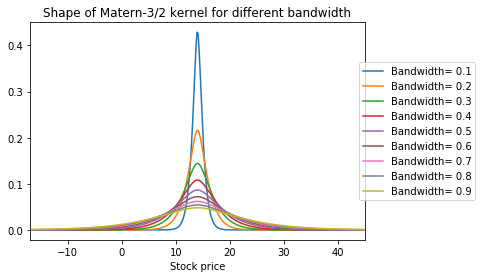

In [213]:
Kernel_Shape(12,1,9)

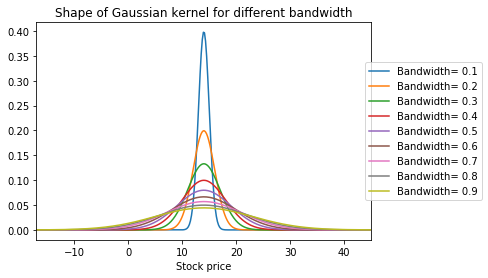

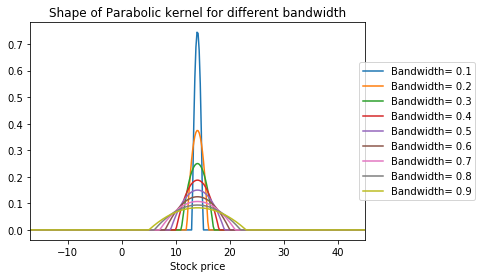

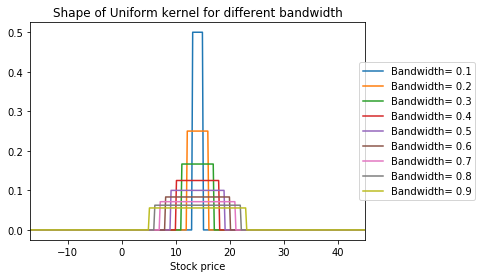

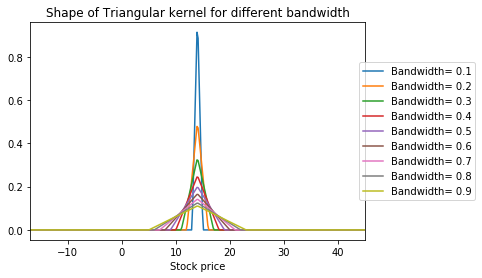

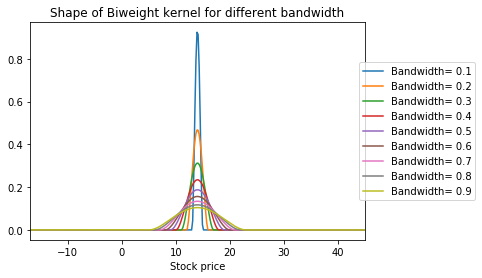

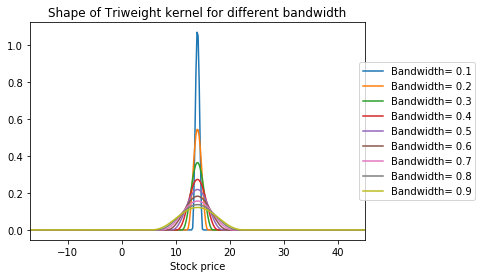

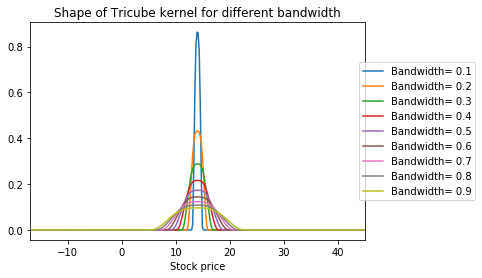

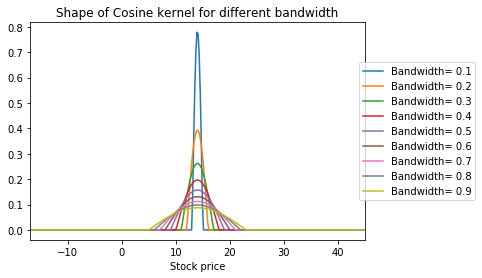

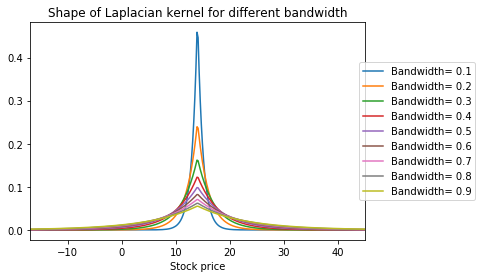

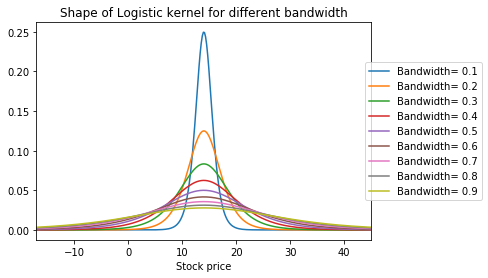

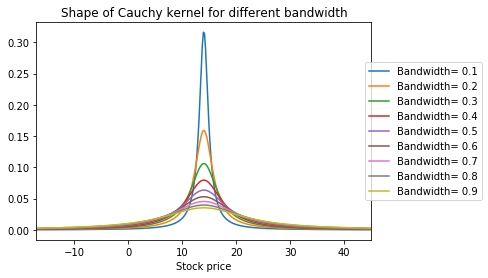

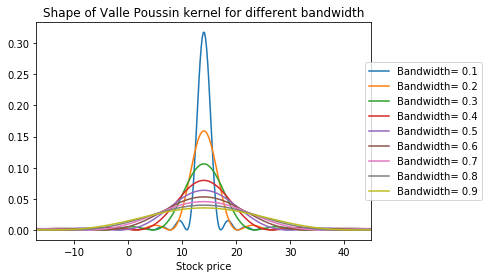

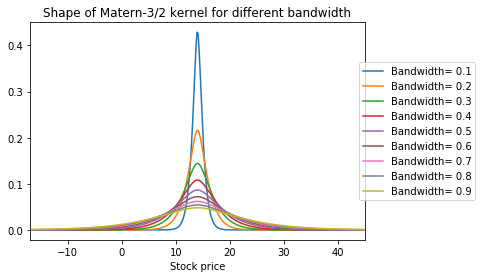

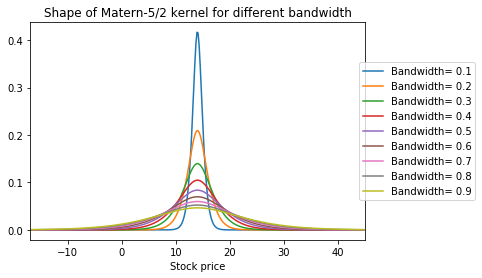

In [215]:
for i in range(0,14):
    Kernel_Shape(i,1,9);

In [ ]:
def Kernel_Shape(num,start,end):
    
    axes = plt.gca()
    axes.set_ylim(-0.02,0.6)
    axes.set_xlim(0,28)
    x=np.linspace(-100,100,1000)
    St_last=x
    
    
    #for i in range(start,end+1):
        #h=i
    i=0.05 
    h=0.7
    plt.plot(x,Kernel(St_last,K,h,M,num),'-',label='Gaussian kernel')#,label='Bandwidth= %s' %i)
        

    plt.plot(np.linspace(0,14,15),np.zeros(15),'b-',label='Dirac Delta')
    plt.plot(np.linspace(14,40,15),np.zeros(15),'b-',)
    plt.plot(np.ones(15)*14,np.linspace(0,1,15),'b-',)
    plt.plot(14,0,'ro',label='strike price')
    
    
    plt.xlabel('Stock price')
    #plt.title("Shape of %s for different bandwidth" %kernel_names[num])
    plt.title("Comparing Dirac delta with Gaussian kernel")
    plt.legend(loc='right',bbox_to_anchor=(0.95,0.9),ncol=1,borderaxespad=0)

    #return plt.show()
    return plt.savefig('Comparison.png',dpi=300)
    

### Rule of thumb H

In [21]:
from tabulate import tabulate 

In [22]:
#Rule_of_thumb=((np.power(2,4/5)*np.std(St_last)*np.exp((np.mean(St_last)/2)-(17/40)*np.power(np.std(St_last),2)))*np.power(M,-1/5))/(12+4*np.power(np.std(St_last),2)+np.power(np.std(St_last),4))


In [23]:
#Rule_of_thumb=((np.power(2,4/5)*np.std(np.log(St_last))*np.exp((np.mean(np.log(St_last))/2)-(17/40)*np.power(np.std(np.log(St_last)),2)))*np.power(M,-1/5))/(12+4*np.power(np.std(np.log(St_last)),2)+np.power(np.std(np.log(St_last)),4))


In [24]:
def Rule_of_thumb(M,St_last):
    
    Rule_of_thumb=1.06*np.std(St_last)*np.power(M,-1/5) #Gaussian Rule of thumb
    
    return Rule_of_thumb

In [249]:
Rule_of_thumb(M,St_last)

In [ ]:
constants=list(np.linspace(0.5,14,55));

In [ ]:
results = [(x, x*Rule_of_thumb(M,St_last)) for x in constants]

In [ ]:
conversion_chart=(tabulate(results,headers=['constant','RoT*constant'],tablefmt='fancy_grid'))

In [ ]:
print(conversion_chart);

## Digital call option Delta

### Closed form solution

In [26]:
def delta_digoption_clform(S,r,K,Vol,T,t):

    d2 = (np.log(S / K) + (r - 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))
    digital_delta_clform = (np.exp(-r*(T-t))*norm.pdf(d2))/(Vol*S*sqrt(T-t))
    
    return digital_delta_clform

In [220]:
delta_digoption_clform(S,r,K,Vol,T,t)

### Using exact spot delta and Single Kernel

In [30]:
num=int(input('Which Kernel would you like to choose: '))

Which Kernel would you like to choose: 0


In [31]:
# Since a digital payoff is discontinous, we used a kernel density estimation

def delta_digital_option(M,h,num):
    Deltas_digital= np.zeros(M)
    Deltas_digital=np.exp(-r*T)*(St_last/S0)*Kernel(St_last,K,h,M,num)                                                                                         
                        
    Delta_digital=np.mean(Deltas_digital)
    return Delta_digital

In [32]:
delta_digital_option(M,Rule_of_thumb(M,St_last),num)

##### Plotting digital option's delta for different bandwidths

In [33]:
delta_constant=np.linspace(0.5,14,55)           #Constants that are multiplied by RoT
delta_bandwidth = delta_constant*Rule_of_thumb(M,St_last) #Array for different 'H' i.e Bandwiths
Delta_digital_Diffh=np.zeros(len(delta_bandwidth))
for i in range(len(delta_bandwidth)):
    h=delta_bandwidth[i]
    Delta_digital_Diffh[i]=delta_digital_option(M,h,num)

In [34]:
def delta_plot_single(constant_start,constant_end):
 
    xaxis_start=constant_start
    xaxis_end=constant_end
    
    fig = plt.figure()
 
    plt.subplot(1,1,1)
    axes = plt.gca()
    axes.set_ylim(delta_digoption_clform(S,r,K,Vol,T,t)*(0.5),delta_digoption_clform(S,r,K,Vol,T,t)*1.5)
    axes.set_xlim(xaxis_start,xaxis_end)
    plt.plot(delta_constant,Delta_digital_Diffh,'o--',label=kernel_names[num])
    plt.plot(delta_digoption_clform(S,r,K,Vol,T,t)*np.ones(21), label='Closed form solution')
    plt.xlabel('Constant')
    plt.ylabel('Digital option delta') 
    plt.title("Digital option's delta by Monte carlo method for different bandwidths")
    plt.legend()
    plt.show()
    
    plt.subplot(1,1,1)
    Error_Delta_digital_Diffh=abs(((Delta_digital_Diffh-delta_digoption_clform(S,r,K,Vol,T,t))*100)/delta_digoption_clform(S,r,K,Vol,T,t))
    axes = plt.gca()
    axes.set_ylim(0.0,5)
    axes.set_xlim(xaxis_start,xaxis_end)

    plt.plot(delta_constant,Error_Delta_digital_Diffh,'o--',label=kernel_names[num])
    plt.plot(15*np.ones(44),"--r",label="15% error")
    plt.plot(10*np.ones(44),"--r",label='10% error')
    plt.plot(5*np.ones(44),"--r",label='5% error')
    plt.plot(2.5*np.ones(44),"--r",label='2.5% error')
    plt.plot(1*np.ones(44),"--r",label='1% error')

    plt.xlabel('Constant')
    plt.ylabel("Digital option delta's percentage error") 
    plt.legend(loc='right',bbox_to_anchor=(1.4,0.5))
    plt.title("Digital option's delta's percentage error for different bandwidth")
    plt.show()   

    plt.subplot(1,1,1)
    Kernel_Shape(num,1,10)

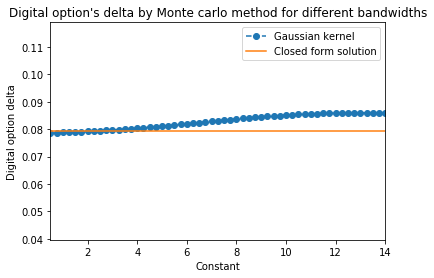

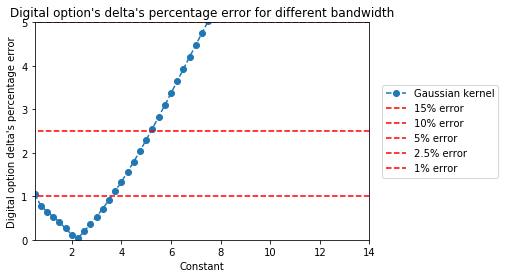

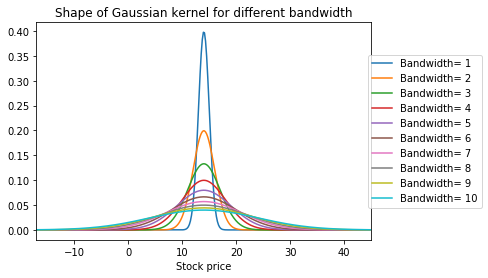

In [35]:
delta_plot_single(0.5,14)

### Using exact spot delta and various different kernels

In [36]:
def delta_digital_option_AllKernels(M,h):
    Deltas_digital_AllKernels= np.zeros(np.shape(Kernel(St_last,K,h,M,77))) 
    Delta_digital_AllKernels=np.zeros(len(Kernel(St_last,K,h,M,77)))
    
    Deltas_digital_AllKernels=np.exp(-r*T)*(St_last/S0)*Kernel(St_last,K,h,M,77)                                                                                      
    
    Delta_digital_AllKernels=np.mean(Deltas_digital_AllKernels,axis=1)
    
    return Delta_digital_AllKernels

In [221]:
delta_constant=np.linspace(0.5,14,55)           #Constants that are multiplied by RoT
delta_bandwidth = delta_constant*Rule_of_thumb(M,St_last) # Array for different 'H' i.e Bandwiths
Delta_digital_AllKernels_DiffH=np.zeros([len(Kernel(St_last,K,h,M,77)),len(delta_bandwidth)])    
for i in range(len(delta_bandwidth)):
    h=delta_bandwidth[i]
    Delta_digital_AllKernels_DiffH[:,i]=delta_digital_option_AllKernels(M,h)
        

In [38]:
Delta_digital_AllKernels_DiffH;  #Each row represents a different kernel and each column represents a diff bandwidth


In [230]:
def delta_plot_AllKernels(kernel_start,kernel_end,constant_start,constant_end):
    
    xaxis_start=constant_start
    xaxis_end=constant_end
    
    axes = plt.gca()
    axes.set_ylim(0.071,0.082)
    #axes.set_ylim(delta_digoption_clform(S,r,K,Vol,T,t)*(0.5),delta_digoption_clform(S,r,K,Vol,T,t)*1.5)
    axes.set_xlim(xaxis_start,xaxis_end)
    
    Design=['--','-']
    
    plt.plot(delta_digoption_clform(S,r,K,Vol,T,t)*np.ones(31),'r',label='closed form')
    
    for i in range(kernel_start,kernel_end):
        if 0<i<=7:
            plt.plot(delta_constant,Delta_digital_AllKernels_DiffH[i],Design[0],label=kernel_names[i])
        elif i>7 or i==0:
            plt.plot(delta_constant,Delta_digital_AllKernels_DiffH[i],Design[1],label=kernel_names[i])

    plt.xlabel('Constant')
    plt.ylabel('Digital option delta')
    plt.title("Digital option's delta using various kernels plotted against different bandwidth")
    plt.legend(loc='right',bbox_to_anchor=(1.5,0.5),ncol=1,borderaxespad=0)

    plt.show()
    #plt.savefig('Delta New', bbox_inches='tight',dpi=300)

    axes = plt.gca()
    axes.set_ylim(0.0,5)
    axes.set_xlim(xaxis_start,xaxis_end)
    
    Error_Delta_digital_AllKernels_DiffH=abs(((Delta_digital_AllKernels_DiffH-delta_digoption_clform(S,r,K,Vol,T,t))*100)/delta_digoption_clform(S,r,K,Vol,T,t))

    plt.plot(1*np.ones(101),"--r",label='1% error')
    plt.plot(3*np.ones(101),"--r",label='3% error')

    for i in range(kernel_start,kernel_end):
        
        if 0<i<=7:
            plt.plot(delta_constant,Error_Delta_digital_AllKernels_DiffH[i],Design[0],label=kernel_names[i])
        elif i>7 or i==0:
            plt.plot(delta_constant,Error_Delta_digital_AllKernels_DiffH[i],Design[1],label=kernel_names[i])

    plt.xlabel('Constant')
    plt.ylabel("Digital option delta's percentage error")
    plt.legend(loc='right',bbox_to_anchor=(1.5,0.45),ncol=1,borderaxespad=0)
    plt.title("Delta's percentage error for various kernels plotted against different bandwidth")
    plt.show()
    #plt.savefig('Delta new error', bbox_inches='tight',dpi=300)
#Finite kernels converge much better!! Best ones are: Triweight, tricube and Cosine

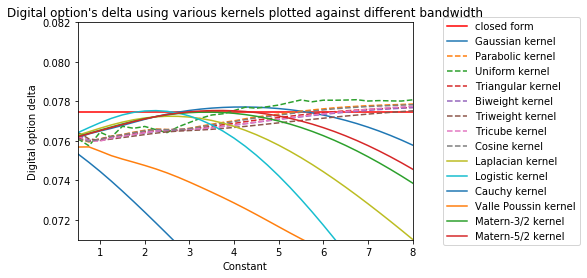

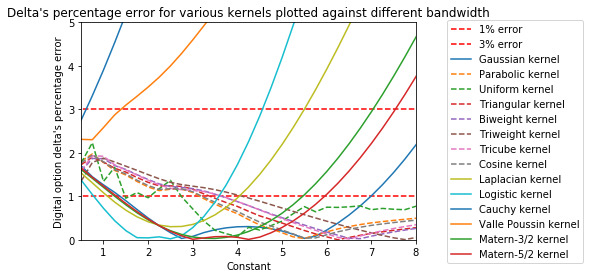

In [232]:
delta_plot_AllKernels(0,14,0.5,8)

In [ ]:
(conversion_chart);

In [ ]:
#All kernel shapes

for i in range(14):
    Kernel_Shape(i,1,10);

## Digital call option Vega

### Closed form solution 

In [41]:
def Vega_digital_clform(S,K,r,T,t,Vol):
    d2 = (np.log(S / K) + (r - 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))
    d1= (np.log(S / K) + (r + 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))
    Vega_digital_clform = -(np.exp(-r*(T-t))*d1*norm.pdf(d2))/(Vol)
    
    return Vega_digital_clform


In [42]:
Vega_digital_clform(S,K,r,T,t,Vol)

### Using exact Spot Vega and Single Kernel

In [ ]:
num=int(input('Which Kernel would you like to choose: '))

In [ ]:
def Vegas_digital(M,h,num):
    Vegas_digital=np.zeros(M)
    Vegas_digital = np.exp(-r*T)*(St_last*(Q-Vol))*Kernel(St_last,K,h,M,num)
    Vega_digital = np.mean(Vegas_digital)

    return Vega_digital

In [ ]:
Vegas_digital(M,Rule_of_thumb(M,St_last),num)

##### Plotting digital option's Vega for different bandwidths

In [ ]:
vega_constant=np.linspace(0.5,14,55)
vega_bandwidth = vega_constant*Rule_of_thumb(M,St_last)   # Array for different 'H' i.e Bandwiths
Vega_digital_Diffh=np.zeros(len(vega_bandwidth))
for i in range(len(vega_bandwidth)):
    h=vega_bandwidth[i]
    Vega_digital_Diffh[i]=Vegas_digital(M,h,num)

In [ ]:
def Vega_plot_single(constant_start,constant_end):                                    

    xaxis_start=constant_start
    xaxis_end=constant_end
    
    axes = plt.gca()
    axes.set_ylim(Vega_digital_clform(S,K,r,T,t,Vol)*0.5,Vega_digital_clform(S,K,r,T,t,Vol)*1.5)
    axes.set_xlim(xaxis_start,xaxis_end)
    plt.plot(vega_constant,Vega_digital_Diffh,'o--',label=kernel_names[num])

    plt.plot(Vega_digital_clform(S,K,r,T,t,Vol)*np.ones(21),label="Closed form solution")

    plt.xlabel('Constant')
    plt.ylabel('Digital option Vega') 
    plt.title("Digital option's Vega by MC method plotted against various bandwidth")
    plt.legend()
    plt.show()
                               
    Error_Vega_digital_Diffh=abs(((Vega_digital_Diffh-Vega_digital_clform(S,K,r,T,t,Vol))*100)/Vega_digital_clform(S,K,r,T,t,Vol))
    axes = plt.gca()
    axes.set_ylim(0.0,10)
    axes.set_xlim(xaxis_start,xaxis_end)

    plt.plot(vega_constant,Error_Vega_digital_Diffh,'o--',label=kernel_names[num])
    plt.plot(5*np.ones(101),'--r',label="5% error ")
    #plt.plot(15*np.ones(101),"--r",label="15% error")
    #plt.plot(10*np.ones(101),"--r",label='10% error')
    plt.plot(1*np.ones(101),"--r",label='1% error') 

    plt.xlabel('Constant')
    plt.ylabel("Digital option Vega's percentage error")
    plt.title("Digital option's Vega's percentage error plotted against various bandwidth")
    plt.legend() 
    plt.show()

    Kernel_Shape(num,1,10)

In [ ]:
Vega_plot_single(0.5,14)

### Using exact Spot Vega and plotting Various Kernels

In [43]:
def Vega_digital_option_AllKernels(M,h):
    Vegas_digital_AllKernels= np.zeros(np.shape(Kernel(St_last,K,h,M,77))) 
    Vega_digital_AllKernels=np.zeros(len(Kernel(St_last,K,h,M,77)))
    
    Vegas_digital_AllKernels=np.exp(-r*T)*(St_last*(Q-Vol))*Kernel(St_last,K,h,M,77)                                                                                      
    
    Vega_digital_AllKernels=np.mean(Vegas_digital_AllKernels,axis=1)
    
    return Vega_digital_AllKernels

In [44]:
vega_constant=np.linspace(0.5,14,55)
vega_bandwidth = vega_constant*Rule_of_thumb(M,St_last) # Array for different 'H' i.e Bandwiths
Vega_digital_AllKernels_DiffH=np.zeros([len(Kernel(St_last,K,h,M,77)),len(vega_bandwidth)])
    
for i in range(len(vega_bandwidth)):
    h=vega_bandwidth[i]
    Vega_digital_AllKernels_DiffH[:,i]=Vega_digital_option_AllKernels(M,h)
        

In [45]:
def vega_plot_AllKernels(kernel_start,kernel_end,constant_start,constant_end):
    
    xaxis_start=constant_start
    xaxis_end=constant_end
    
    axes = plt.gca()
    #axes.set_ylim(0.77,.94)
    axes.set_ylim(Vega_digital_clform(S,K,r,T,t,Vol)*0.5,Vega_digital_clform(S,K,r,T,t,Vol)*1.5)
    axes.set_xlim(xaxis_start,xaxis_end)
    

    plt.plot(Vega_digital_clform(S,K,r,T,t,Vol)*np.ones(51),'-r',label='Closed form sol')
    
    Design=['--','-']
    for i in range(kernel_start,kernel_end):
        
        if 0<i<=7:
            plt.plot(vega_constant,Vega_digital_AllKernels_DiffH[i],Design[0],label=kernel_names[i])
        elif i>7 or i==0:
            plt.plot(vega_constant,Vega_digital_AllKernels_DiffH[i],Design[1],label=kernel_names[i])
            


    plt.xlabel('Constant')
    plt.ylabel('Digital option vega') 
    plt.legend(loc='right',bbox_to_anchor=(1.5,0.5),ncol=1,borderaxespad=0)
    plt.title("Digital option's Vega using various kernels plotted against different bandwidth",x=0.8 ,y=1.04)

    plt.show()
    #plt.savefig('Vega New', bbox_inches='tight',dpi=300)


    Error_Vega_digital_AllKernels_DiffH=abs(((Vega_digital_AllKernels_DiffH-Vega_digital_clform(S,K,r,T,t,Vol))*100)/Vega_digital_clform(S,K,r,T,t,Vol))
    axes = plt.gca()
    axes.set_xlim(xaxis_start,xaxis_end)
    axes.set_ylim(0.0,5)
    
    plt.plot(1*np.ones(101),"--r",label='1% error')
    plt.plot(5*np.ones(101),"--r",label='5% error') 
    for i in range(kernel_start,kernel_end):
        
        if 0<i<=7:
            plt.plot(vega_constant,Error_Vega_digital_AllKernels_DiffH[i],Design[0],label=kernel_names[i])
        elif i>7 or i==0:
            plt.plot(vega_constant,Error_Vega_digital_AllKernels_DiffH[i],Design[1],label=kernel_names[i])


    #plt.plot(20*np.ones(101),'--r',label="20% error ")
    #plt.plot(15*np.ones(101),"--r",label="15% error")   
    plt.xlabel('Constant')
    plt.ylabel("Digital option Vega's percentage error")
    plt.legend(loc='right',bbox_to_anchor=(1.5,0.4),ncol=1,borderaxespad=0)
    plt.title("Vega's percentage error for various kernels plotted against different bandwidth",x=0.8,y=1.04)
    plt.show()
    #plt.savefig('Vega New error', bbox_inches='tight',dpi=300)
    

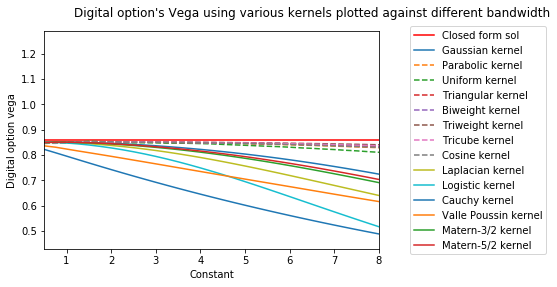

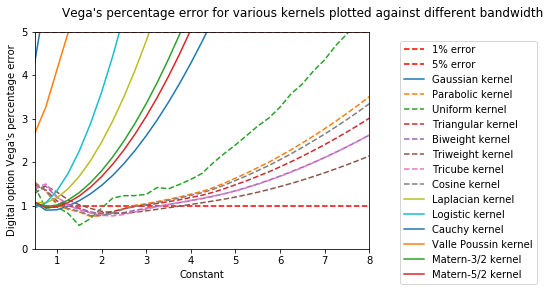

In [46]:
vega_plot_AllKernels(0,14,0.5,8)

In [ ]:
(conversion_chart);

In [ ]:
for i in range(14):
    Kernel_Shape(i,1,10);

## Digital call option Gamma

### Closed form solution

In [47]:
def Gamma_digital_clform(S,K,Vol,r,T,t):
    
    d1 = (np.log(S / K) + (r + 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))

    Gamma_digital_clform = -(np.exp(-r*(T-t))*d1*norm.pdf(d2))/((S0**2)*(Vol**2)*(T-t))
    
    return Gamma_digital_clform

In [48]:
Gamma_digital_clform(S,K,Vol,r,T,t)

###  Function for Gamma

In [49]:
def Gamma_function(St_last,K,h,M,r,T,t,S0,num):
    U=((St_last-K)/h)
    if num==0:
        Gammas_digital= np.exp(-r*(T-t))*(St_last/S0)*(1/h)*norm.pdf((St_last-K)/h)*(((St_last/S0))/h)*(-(St_last-K)/h)
    if num==1:
        Gammas_digital = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-3/2)*U)
    if num==2:
        Gammas_digital=0
    if num==3:
        Gammas_digital = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),1,-1))
    if num==4:
        Gammas_digital = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-15/4)*(1-np.power(U,2))*U)
    if num==5:
        Gammas_digital = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-105/16)*np.power((1-np.power(U,2)),2)*U)
    if num==6:
        Gammas_digital=np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),(70/9)*np.power(1+np.power(U,3),2)*np.power(U,2),(-70/9)*np.power(1-np.power(U,3),2)*np.power(U,2)))
    if num==7:
        Gammas_digital=np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-((np.pi)**2)/8)*np.sin((np.pi/2)*U))
    if num==8:
        Gammas_digital = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(-0.5)*np.exp(-np.sqrt(np.power(U,2)))*np.power(np.power(U,2),-0.5)*U*(((St_last/S0))/h)
    if num==9:
        Gammas_digital = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(-np.power((np.exp(-U)+2+np.exp(U)),-2))*(((St_last/S0))/h)*(np.exp(U)-np.exp(-U))
    if num==10:
        Gammas_digital = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(1/np.pi)*(-1/np.power(1+np.power(U,2),2))*(2*U)*(((St_last/S0))/h)
    if num==11:
        Gammas_digital = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(1/np.pi)*(((St_last/S0))/h)*((2*np.sin(U)*np.cos(U)*np.power(U,2)-2*U*np.power(np.sin(U),2))/np.power(U,4))
    if num==12:
        Gammas_digital = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*(-3*np.sqrt(3)/4)*U*np.exp(-np.sqrt(3*(U**2)))
    if num==13:
        Gammas_digital = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.exp(-np.sqrt(5*U**2))*(-np.sqrt(5)/16)*(U)*(5+((25*(U**2))/np.sqrt(5*U**2)))

        
    if num==77:
        Gammas_digital=np.zeros([14,M])
        
        Gammas_digital[0,:]= np.exp(-r*(T-t))*(St_last/S0)*(1/h)*norm.pdf((St_last-K)/h)*(((St_last/S0))/h)*(-(St_last-K)/h)
        Gammas_digital[1,:] = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-3/2)*U)
        Gammas_digital[2,:]=0
        Gammas_digital[3,:] = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),1,-1))
        Gammas_digital[4,:] = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-15/4)*(1-np.power(U,2))*U)
        Gammas_digital[5,:] = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-105/16)*np.power((1-np.power(U,2)),2)*U)
        Gammas_digital[6,:]=np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),(70/9)*np.power(1+np.power(U,3),2)*np.power(U,2),(-70/9)*np.power(1-np.power(U,3),2)*np.power(U,2)))
        Gammas_digital[7,:]=np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-((np.pi)**2)/8)*np.sin((np.pi/2)*U))
        Gammas_digital[8,:] = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(-0.5)*np.exp(-np.sqrt(np.power(U,2)))*np.power(np.power(U,2),-0.5)*U*(((St_last/S0))/h)
        Gammas_digital[9,:] = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(-np.power((np.exp(-U)+2+np.exp(U)),-2))*(((St_last/S0))/h)*(np.exp(U)-np.exp(-U))
        Gammas_digital[10,:] = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(1/np.pi)*(-1/np.power(1+np.power(U,2),2))*(2*U)*(((St_last/S0))/h)
        Gammas_digital[11,:] = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(1/np.pi)*(((St_last/S0))/h)*((2*np.sin(U)*np.cos(U)*np.power(U,2)-2*U*np.power(np.sin(U),2))/np.power(U,4))
        Gammas_digital[12,:] = np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*(-3*np.sqrt(3)/4)*U*np.exp(-np.sqrt(3*(U**2)))
        Gammas_digital[13,:] =  np.exp(-r*(T-t))*(St_last/S0)*(1/h)*(((St_last/S0))/h)*np.exp(-np.sqrt(5*U**2))*(-np.sqrt(5)/16)*(U)*(5+((25*(U**2))/np.sqrt(5*U**2)))

        
          
    return Gammas_digital

### Using exact Spot Delta and Single Kernel

In [ ]:
num=int(input('Which Kernel would you like to choose: '))

In [ ]:
def Gamma_digital_option(M,St_last,r,T,t,K,S0,h,num):
    
    Gammas_digital=np.zeros(M)
    
    Gammas_digital = Gamma_function(St_last,K,h,M,r,T,t,S0,num)
    
    Gamma_digital=np.mean(Gammas_digital)
    
    return(Gamma_digital)

In [ ]:
Gamma_digital_option(M,St_last,r,T,t,K,S0,Rule_of_thumb(M,St_last),num)

In [ ]:
Gamma_constant=np.linspace(0.5,14,55)
Gamma_bandwidth = Gamma_constant*Rule_of_thumb(M,St_last) # Array for different 'H' i.e Bandwiths
Gamma_digital_Diffh=np.zeros(len(Gamma_bandwidth))
for i in range(len(Gamma_bandwidth)):
    h=Gamma_bandwidth[i]
    Gamma_digital_Diffh[i]=Gamma_digital_option(M,St_last,r,T,t,K,S0,h,num)

In [ ]:
def Gamma_plot_single(constant_start,constant_end):
    xaxis_start=constant_start
    xaxis_end=constant_end
    
    plt.subplot(1,1,1)
    axes = plt.gca()
    axes.set_ylim(Gamma_digital_clform(S,K,Vol,r,T,t)*0.5,Gamma_digital_clform(S,K,Vol,r,T,t)*1.5)
    axes.set_xlim(xaxis_start,xaxis_end)
    plt.plot(Gamma_constant,Gamma_digital_Diffh,'o--',label=kernel_names[num])

    plt.plot(Gamma_digital_clform(S,K,Vol,r,T,t)*np.ones(1001),label="Closed form solution")

    plt.xlabel('Constant')
    plt.ylabel('Digital option Gamma') 
    plt.title("Digital option's Gamma by MC method plotted against various bandwidth")
    plt.legend()
    plt.show()

    plt.subplot(1,1,1)
    Error_gamma_digital=abs(((Gamma_digital_Diffh-Gamma_digital_clform(S,K,Vol,r,T,t))*100)/Gamma_digital_clform(S,K,Vol,r,T,t))
    axes = plt.gca()
    axes.set_ylim(0.0,20)
    axes.set_xlim(xaxis_start,xaxis_end)


    plt.plot(Gamma_constant,Error_gamma_digital,'o--',label=kernel_names[num])
    plt.plot(80*np.ones(101),'--r',label="80% error ")
    plt.plot(60*np.ones(101),"--r",label="60% error")
    plt.plot(40*np.ones(101),"--r",label='40% error')
    plt.plot(5*np.ones(101),"--r",label='5% error')

    plt.xlabel('Constant')
    plt.ylabel("Digital option Gamma's error")
    plt.title("Digital option's Gamma's error plotted against various bandwidth")
    plt.legend() 
    plt.show()

    Kernel_Shape(num,1,10)


In [ ]:
Gamma_plot_single(0.5,14)

### Using exact Spot Delta and various Kernels

In [50]:
def Gamma_digital_option_AllKernels(M,h):
    Gammas_digital_AllKernels= np.zeros(np.shape(Gamma_function(St_last,K,h,M,r,T,t,S0,77))) 
    Gamma_digital_AllKernels=np.zeros(len(Gamma_function(St_last,K,h,M,r,T,t,S0,77)))
    
    Gammas_digital_AllKernels=Gamma_function(St_last,K,h,M,r,T,t,S0,77)                                                                                      
    
    Gamma_digital_AllKernels=np.mean(Gammas_digital_AllKernels,axis=1)
    
    return Gamma_digital_AllKernels

In [51]:
Gamma_constant=np.linspace(0.5,14,55)
Gamma_bandwidth = Gamma_constant*Rule_of_thumb(M,St_last) # Array for different 'H' i.e Bandwiths
Gamma_digital_AllKernels_DiffH=np.zeros([len(Gamma_function(St_last,K,h,M,r,T,t,S0,77)),len(Gamma_bandwidth)])
    
for i in range(len(Gamma_bandwidth)):
    h=Gamma_bandwidth[i]
    Gamma_digital_AllKernels_DiffH[:,i]=Gamma_digital_option_AllKernels(M,h)
        

In [52]:
def Gamma_plot_AllKernels(kernel_start,kernel_end,constant_start,constant_end):
    
    xaxis_start=constant_start
    xaxis_end=constant_end

    axes = plt.gca()
    #axes.set_ylim(0.006,0.026)
    axes.set_ylim(Gamma_digital_clform(S,K,Vol,r,T,t)*0.5,Gamma_digital_clform(S,K,Vol,r,T,t)*1.5)
    axes.set_xlim(xaxis_start,xaxis_end)

    Design=['--','-']

    for i in range(kernel_start,kernel_end):
        if 0<i<=7:
            plt.plot(Gamma_constant,Gamma_digital_AllKernels_DiffH[i],Design[0],label=kernel_names[i])
        elif i>7 or i==0:
            plt.plot(Gamma_constant,Gamma_digital_AllKernels_DiffH[i],Design[1],label=kernel_names[i])

    plt.plot(Gamma_digital_clform(S,K,Vol,r,T,t)*np.ones(51),'-b',label='Closed form sol')


    plt.xlabel('Constant')
    plt.ylabel('Digital option Gamma') 
    plt.legend(loc='right',bbox_to_anchor=(1.5,0.5),ncol=1,borderaxespad=0)
    plt.title("Digital option's Gamma using various kernels plotted against different bandwidth",x=0.8,y=1.04)
    plt.show()
    #plt.savefig('Gamma New', bbox_inches='tight',dpi=300)


    axes = plt.gca()
    axes.set_xlim(xaxis_start,xaxis_end)
    axes.set_ylim(0.0,20)

    Error_Gamma_digital_AllKernels_DiffH=abs((Gamma_digital_AllKernels_DiffH-Gamma_digital_clform(S,K,Vol,r,T,t))*100)/Gamma_digital_clform(S,K,Vol,r,T,t)

    plt.plot(1*np.ones(101),"--r",label='1% error')
    plt.plot(5*np.ones(101),"--r",label='5% error') 
    for i in range(kernel_start,kernel_end):
        if 0<i<=7:
            plt.plot(Gamma_constant,Error_Gamma_digital_AllKernels_DiffH[i],Design[0],label=kernel_names[i])
        elif i>7 or i==0:
            plt.plot(Gamma_constant,Error_Gamma_digital_AllKernels_DiffH[i],Design[1],label=kernel_names[i])


    #plt.plot(20*np.ones(101),'--r',label="20% error ")
    #plt.plot(15*np.ones(101),"--r",label="15% error")   
    plt.xlabel('Constant')
    plt.ylabel("Digital option Gamma's percentage error")
    plt.legend(loc='right',bbox_to_anchor=(1.5,0.4),ncol=1,borderaxespad=0)
    plt.title("Gamma's percentage error for various kernels plotted against different bandwidth",x=0.8,y=1.04)
    plt.show()
    #plt.savefig('Gamma New error', bbox_inches='tight',dpi=300)
    

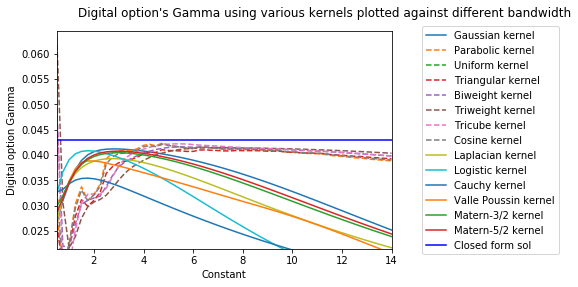

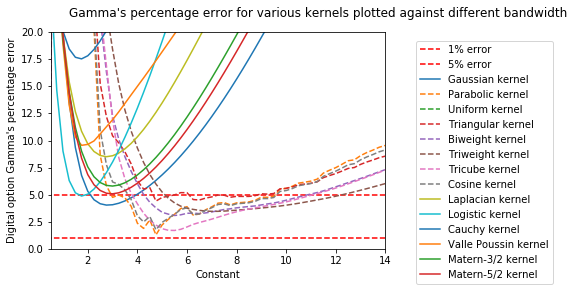

In [53]:
Gamma_plot_AllKernels(0,14,0.5,14)

### Bandwidth rescaling and Comparing kernels

In [54]:
import scipy.integrate as integrate

In [55]:
def integrand(num,U):
        
    if num==0:
        Kernel1 = norm.pdf(U) 
    elif num==1:
        Kernel1 = ((3/4)*(1-np.power(U,2))*np.where(abs(U)<=1,1,0)) #Parabolic kernel
    elif num==2:
        Kernel1 = ((1/2)*np.where(abs(U)<=1,1,0)) #Uniform kernel
    elif num==3:
        Kernel1 = ((1-abs(U))*np.where(abs(U)<=1,1,0)) #traingular kernel
    elif num==4:
        Kernel1 = ((15/16)*np.power((1-np.power(U,2)),2)*(np.where(abs(U)<=1,1,0))) #Biweight kernel
    elif num==5:
        Kernel1 = ((35/32)*np.power((1-np.power(U,2)),3)*(np.where(abs(U)<=1,1,0))) #Triweight
    elif num==6:
        Kernel1 = ((70/81)*np.power((1-np.power(abs(U),3)),3)*(np.where(abs(U)<=1,1,0)))#Tricube kernel
    elif num==7:
        Kernel1 = ((np.pi/4)*np.cos((np.pi/2)*U)*(np.where(abs(U)<=1,1,0)))  #Cosine kernel
    elif num==8:
        Kernel1 = ((1/2)*np.exp(-abs(U))) #Laplacian kernel    
    elif num==9:
        Kernel1 = (1/(np.exp(U)+2+np.exp(-U))) #logistic kernel
    elif num==10:
        Kernel1 = (1/(np.pi*(1+np.power(U,2)))) #Cauchy kernel 
    elif num==11:
        Kernel1 = ((np.power(np.sin(U),2))/(np.pi*np.power(U,2)))  #Valle Poussin kernen  
    elif num==12:
        Kernel1 = ((1/4)*(1+abs(U))*np.exp(-abs(U))) #1st Order sargan kernel
    elif num==13:
        Kernel1 = ((1/6)*(1+abs(U)+0.5*np.power(U,2))*np.exp(-abs(U))) #2nd Order sargan kernel
    
    return Kernel1

In [56]:
def bandwidth_rescaling(h1,num1,num2):
    
    num=num1
    if num1==0 or 1 or 2 or 3 or 4 or 5 or 6 or 7:
         sigma_kerne11= integrate.quad(lambda U: U**2*integrand(num,U) , -np.inf, 1)[0]
    elif num1== 8 or 9 or 10 or 11 or 12 or 13 or 14:
        sigma_kerne11=integrate.quad(lambda U: U**2*integrand(num,U) , -np.inf, np.inf)[0]
    
    num=num2
    if num2==0 or 1 or 2 or 3 or 4 or 5 or 6 or 7:
        sigma_kerne12=integrate.quad(lambda U: U**2*integrand(num,U) , -np.inf, 1)[0]
    elif num2==8 or 9 or 10 or 11 or 12 or 13 or 14:
        sigma_kerne12=integrate.quad(lambda U: U**2*integrand(num,U) , -np.inf, np.inf)[0]
        
        
    h2=h1*(sigma_kerne11/sigma_kerne12)
        
    return h2   

In [ ]:
h1=float(input('What would you like bandwidth of the first kernel to be: ')) #Chossing h1

In [ ]:
num1=int(input('What would you like first kernel to be: ')) #Choosing kernel 1

In [ ]:
num2=int(input('What would you like second kernel to be: '))  #Choosing kernel 2

In [ ]:
h2=bandwidth_rescaling(h1,num1,num2)

In [ ]:
h2

In [ ]:
def Kernel_Compare(h1,h2,num1,num2):
    
    axes = plt.gca()
    #axes.set_ylim(0.00,0.002)
    axes.set_xlim(-17,45)
    x=np.linspace(-100,100,1000)
    St_last=x
    
    
    h=h1
    plt.plot(x,Kernel(St_last,K,h,M,num1),'-',label=kernel_names[num1])
    
    h=h2
    plt.plot(x,Kernel(St_last,K,h,M,num2),'-',label=kernel_names[num2])


    plt.xlabel('Stock price')
    plt.title("Shape of %s and %s " %(kernel_names[num1],kernel_names[num2]))
    plt.legend()

    return plt.show()

In [ ]:
Kernel_Compare(h1,h2,num1,num2)

## Digital call option Vomma

### Closed form solution

In [57]:
def Vomma_digital_clform(S,K,Vol,r,T,t):
    d1 = (np.log(S / K) + (r + 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))
    Vomma_clform=(norm.pdf(d2)/(Vol**2))*np.exp(-r*(T-t))*(2*d1-(d1**2)*d2-Vol*np.sqrt(T-t))
    
    return Vomma_clform

In [233]:
Vomma_digital_clform(S,K,Vol,r,T,t)

### Function for Vomma

In [59]:
def Vomma_function(St_last,K,h,M,r,T,t,S0,Vol,num):
    U=((St_last-K)/h)
    
    if num==0:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*(norm.pdf((St_last-K)/h)*(-(St_last-K)/h)*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+norm.pdf(U)*(-St_last+St_last*np.power(-Vol+Q,2))) #Gaussian kernel
    if num==1:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1),0,(-3/2)*U)*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((3/4)*(1-np.power(U,2))*np.where(abs(U)<=1,1,0))*(-St_last+St_last*np.power(-Vol+Q,2))) #Parabolic kernel
    if num==2:
        Vommas_digital=0
    if num==3:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),1,-1))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((1-abs(U))*np.where(abs(U)<=1,1,0))*(-St_last+St_last*np.power(-Vol+Q,2))) #Triangular kernel
    if num==4:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1),0,(-15/4)*(1-np.power(U,2))*U)*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((15/16)*np.power((1-np.power(U,2)),2)*(np.where(abs(U)<=1,1,0)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Biweight kernel
    if num==5:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1),0,(-105/16)*np.power((1-np.power(U,2)),2)*U)*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((35/32)*np.power((1-np.power(U,2)),3)*(np.where(abs(U)<=1,1,0)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Triwieght kernel
    if num==6:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),(70/9)*np.power(1+np.power(U,3),2)*np.power(U,2),(-70/9)*np.power(1-np.power(U,3),2)*np.power(U,2)))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((70/81)*np.power((1-np.power(abs(U),3)),3)*(np.where(abs(U)<=1,1,0)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Tricube
    if num==7:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1),0,(-((np.pi)**2)/8)*np.sin((np.pi/2)*U))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((np.pi/4)*np.cos((np.pi/2)*U)*(np.where(abs(U)<=1,1,0)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Cosine kernel
    if num==8:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*((-0.5)*np.exp(-np.sqrt(np.power(U,2)))*np.power(np.power(U,2),-0.5)*U*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((1/2)*np.exp(-abs(U)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Laplacian kernel
    if num==9:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*((-np.power((np.exp(-U)+2+np.exp(U)),-2))*(np.exp(U)-np.exp(-U))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+(1/(np.exp(U)+2+np.exp(-U)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Logistic kernel
    if num==10:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*((1/np.pi)*(-1/np.power(1+np.power(U,2),2))*(2*U)*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+(1/(np.pi*(1+np.power(U,2))))*(-St_last+St_last*np.power(-Vol+Q,2))) #Cautchy kernel
    if num==11:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*((1/np.pi)*((2*np.sin(U)*np.cos(U)*np.power(U,2)-2*U*np.power(np.sin(U),2))/np.power(U,4))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((np.power(np.sin(U),2))/(np.pi*np.power(U,2)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Valle-poussin kernel
    if num==12:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*((-3*np.sqrt(3)/4)*U*np.exp(-np.sqrt(3*(U**2)))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+(np.sqrt(3)/4)*(1+np.sqrt(3)*abs(U))*np.exp(-np.sqrt(3)*abs(U))*(-St_last+St_last*np.power(-Vol+Q,2))) #1st Sargan kernel
    if num==13:
        Vommas_digital = np.exp(-r*(T-t))*(1/h)*(np.exp(-np.sqrt(5*U**2))*(-np.sqrt(5)/16)*(U)*(5+((25*(U**2))/np.sqrt(5*U**2)))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+(3*np.sqrt(5)/16)*(1+np.sqrt(5)*abs(U)+(5/3)*abs(U)**2)*np.exp(-np.sqrt(5)*abs(U))*(-St_last+St_last*np.power(-Vol+Q,2))) #2nd kernel
  
    if num==77:
        Vommas_digital=np.zeros([14,M])
        
        Vommas_digital[0,:]  = np.exp(-r*(T-t))*(1/h)*(norm.pdf((St_last-K)/h)*(-(St_last-K)/h)*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+norm.pdf(U)*(-St_last+St_last*np.power(-Vol+Q,2))) #Gaussian kernel
        Vommas_digital[1,:]  = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1),0,(-3/2)*U)*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((3/4)*(1-np.power(U,2))*np.where(abs(U)<=1,1,0))*(-St_last+St_last*np.power(-Vol+Q,2))) #Parabolic kernel
        Vommas_digital[2,:]  = 0
        Vommas_digital[3,:]  = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),1,-1))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((1-abs(U))*np.where(abs(U)<=1,1,0))*(-St_last+St_last*np.power(-Vol+Q,2))) #Triangular kernel
        Vommas_digital[4,:]  = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1),0,(-15/4)*(1-np.power(U,2))*U)*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((15/16)*np.power((1-np.power(U,2)),2)*(np.where(abs(U)<=1,1,0)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Biweight kernel
        Vommas_digital[5,:]  = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1),0,(-105/16)*np.power((1-np.power(U,2)),2)*U)*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((35/32)*np.power((1-np.power(U,2)),3)*(np.where(abs(U)<=1,1,0)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Triwieght kernel
        Vommas_digital[6,:]  = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),(70/9)*np.power(1+np.power(U,3),2)*np.power(U,2),(-70/9)*np.power(1-np.power(U,3),2)*np.power(U,2)))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((70/81)*np.power((1-np.power(abs(U),3)),3)*(np.where(abs(U)<=1,1,0)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Tricube
        Vommas_digital[7,:]  = np.exp(-r*(T-t))*(1/h)*(np.where((U<=-1)|(U>=1),0,(-((np.pi)**2)/8)*np.sin((np.pi/2)*U))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((np.pi/4)*np.cos((np.pi/2)*U)*(np.where(abs(U)<=1,1,0)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Cosine kernel
        Vommas_digital[8,:]  = np.exp(-r*(T-t))*(1/h)*((-0.5)*np.exp(-np.sqrt(np.power(U,2)))*np.power(np.power(U,2),-0.5)*U*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((1/2)*np.exp(-abs(U)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Laplacian kernel
        Vommas_digital[9,:]  = np.exp(-r*(T-t))*(1/h)*((-np.power((np.exp(-U)+2+np.exp(U)),-2))*(np.exp(U)-np.exp(-U))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+(1/(np.exp(U)+2+np.exp(-U)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Logistic kernel
        Vommas_digital[10,:] = np.exp(-r*(T-t))*(1/h)*((1/np.pi)*(-1/np.power(1+np.power(U,2),2))*(2*U)*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+(1/(np.pi*(1+np.power(U,2))))*(-St_last+St_last*np.power(-Vol+Q,2))) #Cautchy kernel
        Vommas_digital[11,:] = np.exp(-r*(T-t))*(1/h)*((1/np.pi)*((2*np.sin(U)*np.cos(U)*np.power(U,2)-2*U*np.power(np.sin(U),2))/np.power(U,4))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+((np.power(np.sin(U),2))/(np.pi*np.power(U,2)))*(-St_last+St_last*np.power(-Vol+Q,2))) #Valle-poussin kernel
        Vommas_digital[12,:] = np.exp(-r*(T-t))*(1/h)*((-3*np.sqrt(3)/4)*U*np.exp(-np.sqrt(3*(U**2)))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+(np.sqrt(3)/4)*(1+np.sqrt(3)*abs(U))*np.exp(-np.sqrt(3)*abs(U))*(-St_last+St_last*np.power(-Vol+Q,2))) #1st Sargan kernel
        Vommas_digital[13,:] = np.exp(-r*(T-t))*(1/h)*(np.exp(-np.sqrt(5*U**2))*(-np.sqrt(5)/16)*(U)*(5+((25*(U**2))/np.sqrt(5*U**2)))*(((-Vol+Q)*St_last)/h)*(St_last*(-Vol+Q))+(3*np.sqrt(5)/16)*(1+np.sqrt(5)*abs(U)+(5/3)*abs(U)**2)*np.exp(-np.sqrt(5)*abs(U))*(-St_last+St_last*np.power(-Vol+Q,2))) 

    return Vommas_digital            

### Showing for a single Kernel

In [ ]:
num=int(input('Which Kernel would you like to choose: '))

In [ ]:
def Vomma_digital_option(M,St_last,r,T,t,K,Vol,S0,h,num):
    
    Vommas_digital=np.zeros(M)
    
    Vommas_digital = Vomma_function(St_last,K,h,M,r,T,t,S0,Vol,num) 

    Vomma_digital=np.mean(Vommas_digital)
    
    return(Vomma_digital)

In [ ]:
Vomma_digital_option(M,St_last,r,T,t,K,Vol,S0,Rule_of_thumb(M,St_last),num)

In [ ]:
Vomma_constant=np.linspace(0.5,14,55)
Vomma_bandwidth = Vomma_constant*Rule_of_thumb(M,St_last)   # Array for different 'H' i.e Bandwiths
Vomma_digital_Diffh=np.zeros(len(Vomma_bandwidth))
for i in range(len(Vomma_bandwidth)):
    h=Vomma_bandwidth[i]
    Vomma_digital_Diffh[i]=Vomma_digital_option(M,St_last,r,T,t,K,Vol,S0,h,num)

In [ ]:
def Vomma_plot_single(constant_start,constant_end):
    
    xaxis_start=constant_start
    xaxis_end=constant_end
    
    plt.subplot(1,1,1)
    axes = plt.gca()
    axes.set_ylim(Vomma_digital_clform(S,K,Vol,r,T,t)*1.5,Vomma_digital_clform(S,K,Vol,r,T,t)*0.5)
    axes.set_xlim(xaxis_start,xaxis_end)
    plt.plot(Vomma_constant,Vomma_digital_Diffh,'o--',label=kernel_names[num])

    plt.plot(Vomma_digital_clform(S,K,Vol,r,T,t)*np.ones(1001),label="Closed form solution")

    plt.xlabel('Constant')
    plt.ylabel('Digital option Vomma') 
    plt.title("Digital option's Vomma by MC method plotted against various bandwidth")
    plt.legend()
    plt.show()

    plt.subplot(1,1,1)
    Error_Vomma_digital=abs(((Vomma_digital_Diffh-Vomma_digital_clform(S,K,Vol,r,T,t))*100)/Vomma_digital_clform(S,K,Vol,r,T,t))
    axes = plt.gca()
    axes.set_ylim(0.0,30)
    axes.set_xlim(xaxis_start,xaxis_end)


    plt.plot(Vomma_constant,Error_Vomma_digital,'o--',label=kernel_names[num])
    #plt.plot(80*np.ones(101),'--r',label="80% error ")
    #plt.plot(60*np.ones(101),"--r",label="60% error")
    plt.plot(2.5*np.ones(101),"--r",label='2.5% error')
    plt.plot(5*np.ones(101),"--r",label='5% error')

    plt.xlabel('Constant')
    plt.ylabel("Digital option Vomma's error")
    plt.title("Digital option's Vomma's error plotted against various bandwidth")
    plt.legend() 
    plt.show()

    Kernel_Shape(num,1,10)


In [ ]:
Vomma_plot_single(0.5,14)

### Showing for all kernels togather

In [60]:
def Vomma_digital_option_AllKernels(M,St_last,r,T,t,K,Vol,S0,h):
    Vommmas_digital_AllKernels= np.zeros(np.shape(Vomma_function(St_last,K,h,M,r,T,t,S0,Vol,77))) 
    Vomma_digital_AllKernels=np.zeros(len(Vomma_function(St_last,K,h,M,r,T,t,S0,Vol,77)))
    
    Vommas_digital_AllKernels=Vomma_function(St_last,K,h,M,r,T,t,S0,Vol,77)                                                                                      
    
    Vomma_digital_AllKernels=np.mean(Vommas_digital_AllKernels,axis=1)
    
    return Vomma_digital_AllKernels

In [234]:
Vomma_constant=np.linspace(0.5,14,55)
Vomma_bandwidth = Vomma_constant*Rule_of_thumb(M,St_last) # Array for different 'H' i.e Bandwiths
Vomma_digital_AllKernels_DiffH=np.zeros([len(Vomma_function(St_last,K,h,M,r,T,t,S0,Vol,77)),len(Vomma_bandwidth)])
    
for i in range(len(Vomma_bandwidth)):
    h=Vomma_bandwidth[i]
    Vomma_digital_AllKernels_DiffH[:,i]=Vomma_digital_option_AllKernels(M,St_last,r,T,t,K,Vol,S0,h)
        

In [239]:
def Vomma_plot_AllKernels(kernel_start,kernel_end,constant_start,constant_end):
    
    xaxis_start=constant_start
    xaxis_end=constant_end

    axes = plt.gca()
    axes.set_ylim(Vomma_digital_clform(S,K,Vol,r,T,t)*1.5,Vomma_digital_clform(S,K,Vol,r,T,t)*0.5)
    axes.set_xlim(xaxis_start,xaxis_end)

    Design=['--','-']

    for i in range(kernel_start,kernel_end):
        if 0<i<=7:
            plt.plot(Vomma_constant,Vomma_digital_AllKernels_DiffH[i],Design[0],label=kernel_names[i])
        elif i>7 or i==0:
            plt.plot(Vomma_constant,Vomma_digital_AllKernels_DiffH[i],Design[1],label=kernel_names[i])

    plt.plot(Vomma_digital_clform(S,K,Vol,r,T,t)*np.ones(51),'-b',label='Closed form sol')


    plt.xlabel('Constant')
    plt.ylabel('Digital option Vomma') 
    plt.legend(loc='right',bbox_to_anchor=(1.5,0.5),ncol=1,borderaxespad=0)
    plt.title("Digital option's Vomma using various kernels plotted against different bandwidth",x=0.7,y=1.03)

    plt.show()
    #plt.savefig('Vomma new', bbox_inches='tight',dpi=300)
    
    axes = plt.gca()
    axes.set_xlim(xaxis_start,xaxis_end)
    axes.set_ylim(0.0,20)

    Error_Vomma_digital_AllKernels_DiffH=abs((Vomma_digital_AllKernels_DiffH-Vomma_digital_clform(S,K,Vol,r,T,t))*100/Vomma_digital_clform(S,K,Vol,r,T,t))

    plt.plot(2.5*np.ones(101),"--r",label='2.5% error')
    plt.plot(5*np.ones(101),"--r",label='5% error') 
    for i in range(kernel_start,kernel_end):
        if 0<i<=7:
            plt.plot(Vomma_constant,Error_Vomma_digital_AllKernels_DiffH[i],Design[0],label=kernel_names[i])
        elif i>7 or i==0:
            plt.plot(Vomma_constant,Error_Vomma_digital_AllKernels_DiffH[i],Design[1],label=kernel_names[i])


    #plt.plot(20*np.ones(101),'--r',label="20% error ")
    #plt.plot(15*np.ones(101),"--r",label="15% error")   
    plt.xlabel('Constant')
    plt.ylabel("Digital option Vomma's percentage error")
    plt.legend(loc='right',bbox_to_anchor=(1.5,0.5),ncol=1,borderaxespad=0)
    plt.title("Vomma's percentage error for various kernels plotted against different bandwidth",x=0.7,y=1.03)
    #plt.show()
    plt.savefig('Vomma new error', bbox_inches='tight',dpi=300)


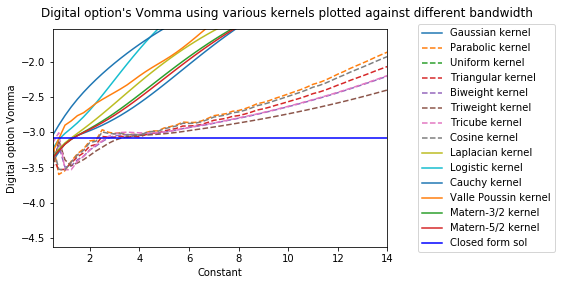

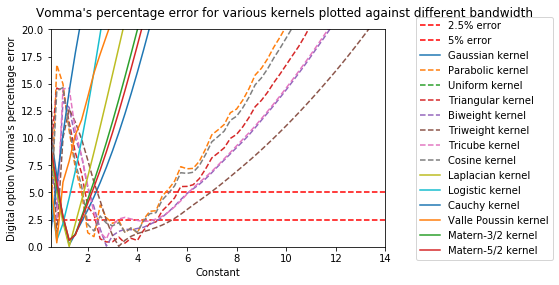

In [240]:
Vomma_plot_AllKernels(0,14,0.5,14)

## Digital call option Vanna

### Closed form solution

In [68]:
def Vanna_digital_clform(S,K,Vol,r,T,t):
    d1 = (np.log(S / K) + (r + 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * Vol ** 2) * T) / (Vol * np.sqrt(T))
    Vanna_clform = - (np.exp(-r*(T-t))/Vol)*(norm.pdf(d2)/(S*Vol*np.sqrt(T-t)))*(1-d1*d2)
    
    return Vanna_clform

In [241]:
Vanna_digital_clform(S,K,Vol,r,T,t)

### Vanna function

In [70]:
def Vanna_function(St_last,K,h,M,r,T,t,S0,Vol,num):
    
    U=((St_last-K)/h)
    
    if num==0:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(norm.pdf(U)/S0+norm.pdf((St_last-K)/h)*(((St_last/S0))/h)*(-(St_last-K)/h))
    if num==1:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((3/4)*(1-np.power(U,2))*np.where(abs(U)<=1,1,0))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-3/2)*U))
    if num==2:
        Vannas_digital=0 
    if num==3:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((1-abs(U))*np.where(abs(U)<=1,1,0))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),1,-1)))
    if num==4:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((15/16)*np.power((1-np.power(U,2)),2)*(np.where(abs(U)<=1,1,0)))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-15/4)*(1-np.power(U,2))*U))
    if num==5:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((35/32)*np.power((1-np.power(U,2)),3)*(np.where(abs(U)<=1,1,0)))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-105/16)*np.power((1-np.power(U,2)),2)*U))
    if num==6:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((70/81)*np.power((1-np.power(abs(U),3)),3)*(np.where(abs(U)<=1,1,0)))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),(70/9)*np.power(1+np.power(U,3),2)*np.power(U,2),(-70/9)*np.power(1-np.power(U,3),2)*np.power(U,2))))
    if num==7:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((np.pi/4)*np.cos((np.pi/2)*U)*(np.where(abs(U)<=1,1,0)))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-((np.pi)**2)/8)*np.sin((np.pi/2)*U)))
    if num==8:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((1/2)*np.exp(-abs(U)))/S0+(-0.5)*np.exp(-np.sqrt(np.power(U,2)))*np.power(np.power(U,2),-0.5)*U*(((St_last/S0))/h))
    if num==9:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*((1/(np.exp(U)+2+np.exp(-U)))/S0+(-np.power((np.exp(-U)+2+np.exp(U)),-2))*(((St_last/S0))/h)*(np.exp(U)-np.exp(-U)))
    if num==10:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*((1/(np.pi*(1+np.power(U,2))))/S0+(1/np.pi)*(-1/np.power(1+np.power(U,2),2))*(2*U)*(((St_last/S0))/h))
    if num==11:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((np.power(np.sin(U),2))/(np.pi*np.power(U,2)))/S0+(1/np.pi)*(((St_last/S0))/h)*((2*np.sin(U)*np.cos(U)*np.power(U,2)-2*U*np.power(np.sin(U),2))/np.power(U,4)))
    if num==12:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*((np.sqrt(3)/4)*(1+np.sqrt(3)*abs(U))*np.exp(-np.sqrt(3)*abs(U))/S0+(((St_last/S0))/h)*(-3*np.sqrt(3)/4)*U*np.exp(-np.sqrt(3*(U**2))))
    if num==13:
        Vannas_digital=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*((3*np.sqrt(5)/16)*(1+np.sqrt(5)*abs(U)+(5/3)*abs(U)**2)*np.exp(-np.sqrt(5)*abs(U))/S0+(((St_last/S0))/h)*np.exp(-np.sqrt(5*U**2))*(-np.sqrt(5)/16)*(U)*(5+((25*(U**2))/np.sqrt(5*U**2))))
        
    if num==77:
        Vannas_digital=np.zeros([14,M])
        
        Vannas_digital[0,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(norm.pdf(U)/S0+norm.pdf((St_last-K)/h)*(((St_last/S0))/h)*(-(St_last-K)/h))
        Vannas_digital[1,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((3/4)*(1-np.power(U,2))*np.where(abs(U)<=1,1,0))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-3/2)*U))
        Vannas_digital[2,:]=0
        Vannas_digital[3,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((1-abs(U))*np.where(abs(U)<=1,1,0))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),1,-1)))
        Vannas_digital[4,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((15/16)*np.power((1-np.power(U,2)),2)*(np.where(abs(U)<=1,1,0)))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-15/4)*(1-np.power(U,2))*U))
        Vannas_digital[5,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((35/32)*np.power((1-np.power(U,2)),3)*(np.where(abs(U)<=1,1,0)))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-105/16)*np.power((1-np.power(U,2)),2)*U))
        Vannas_digital[6,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((70/81)*np.power((1-np.power(abs(U),3)),3)*(np.where(abs(U)<=1,1,0)))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1)|(U==0),0,np.where((U>-1)&(U<0),(70/9)*np.power(1+np.power(U,3),2)*np.power(U,2),(-70/9)*np.power(1-np.power(U,3),2)*np.power(U,2))))
        Vannas_digital[7,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((np.pi/4)*np.cos((np.pi/2)*U)*(np.where(abs(U)<=1,1,0)))/S0+(((St_last/S0))/h)*np.where((U<=-1)|(U>=1),0,(-((np.pi)**2)/8)*np.sin((np.pi/2)*U)))
        Vannas_digital[8,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((1/2)*np.exp(-abs(U)))/S0+(-0.5)*np.exp(-np.sqrt(np.power(U,2)))*np.power(np.power(U,2),-0.5)*U*(((St_last/S0))/h))
        Vannas_digital[9,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*((1/(np.exp(U)+2+np.exp(-U)))/S0+(-np.power((np.exp(-U)+2+np.exp(U)),-2))*(((St_last/S0))/h)*(np.exp(U)-np.exp(-U)))
        Vannas_digital[10,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*((1/(np.pi*(1+np.power(U,2))))/S0+(1/np.pi)*(-1/np.power(1+np.power(U,2),2))*(2*U)*(((St_last/S0))/h))
        Vannas_digital[11,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*(((np.power(np.sin(U),2))/(np.pi*np.power(U,2)))/S0+(1/np.pi)*(((St_last/S0))/h)*((2*np.sin(U)*np.cos(U)*np.power(U,2)-2*U*np.power(np.sin(U),2))/np.power(U,4)))
        Vannas_digital[12,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*((np.sqrt(3)/4)*(1+np.sqrt(3)*abs(U))*np.exp(-np.sqrt(3)*abs(U))/S0+(((St_last/S0))/h)*(-3*np.sqrt(3)/4)*U*np.exp(-np.sqrt(3*(U**2))))
        Vannas_digital[13,:]=np.exp(-r*T)*(1/h)*(-Vol+Q)*St_last*((3*np.sqrt(5)/16)*(1+np.sqrt(5)*abs(U)+(5/3)*abs(U)**2)*np.exp(-np.sqrt(5)*abs(U))/S0+(((St_last/S0))/h)*np.exp(-np.sqrt(5*U**2))*(-np.sqrt(5)/16)*(U)*(5+((25*(U**2))/np.sqrt(5*U**2))))
 
    return Vannas_digital    

### Showing for single kernel

In [ ]:
num=int(input('Which Kernel would you like to choose: '))

In [ ]:
def Vanna_digital_option(M,St_last,r,T,t,K,Vol,S0,h,num):
    
    Vannas_digital=np.zeros(M)
    
    Vannas_digital = Vanna_function(St_last,K,h,M,r,T,t,S0,Vol,num) 

    Vanna_digital=np.mean(Vannas_digital)
    
    return(Vanna_digital)

In [ ]:
Vanna_digital_option(M,St_last,r,T,t,K,Vol,S0,Rule_of_thumb(M,St_last),num)

In [ ]:
Vanna_constant=np.linspace(0.5,14,55)
Vanna_bandwidth = Vanna_constant*Rule_of_thumb(M,St_last)#Array for different 'H' i.e Bandwiths
Vanna_digital_Diffh=np.zeros(len(Vanna_bandwidth))
for i in range(len(Vanna_bandwidth)):
    h=Vanna_bandwidth[i]
    Vanna_digital_Diffh[i]=Vanna_digital_option(M,St_last,r,T,t,K,Vol,S0,h,num)

In [ ]:
def Vanna_plot_single(constant_start,constant_end):
    
    xaxis_start=constant_start
    xaxis_end=constant_end
    
    plt.subplot(1,1,1)
    axes = plt.gca()
    axes.set_ylim(Vanna_digital_clform(S,K,Vol,r,T,t)*1.5,Vanna_digital_clform(S,K,Vol,r,T,t)*0.5)
    axes.set_xlim(xaxis_start,xaxis_end)
    plt.plot(Vanna_constant,Vanna_digital_Diffh,'o--',label=kernel_names[num])

    plt.plot(Vanna_digital_clform(S,K,Vol,r,T,t)*np.ones(1001),label="Closed form solution")

    plt.xlabel('Constant')
    plt.ylabel('Digital option Vanna') 
    plt.title("Digital option's Vanna by MC method plotted against various bandwidth")
    plt.legend()
    plt.show()

    plt.subplot(1,1,1)
    Error_Vanna_digital=abs(((Vanna_digital_Diffh-Vanna_digital_clform(S,K,Vol,r,T,t))*100)/Vanna_digital_clform(S,K,Vol,r,T,t))
    axes = plt.gca()
    axes.set_ylim(0.0,20)
    axes.set_xlim(xaxis_start,xaxis_end)

    plt.plot(Vanna_constant,Error_Vanna_digital,'o--',label=kernel_names[num])
    #plt.plot(80*np.ones(101),'--r',label="80% error ")
    #plt.plot(60*np.ones(101),"--r",label="60% error")
    plt.plot(2.5*np.ones(101),"--r",label='2.5% error')
    plt.plot(5*np.ones(101),"--r",label='5% error')

    plt.xlabel('Constant')
    plt.ylabel("Digital option Vanna's error")
    plt.title("Digital option's Vanna's error plotted against various bandwidth")
    plt.legend() 
    plt.show()

    Kernel_Shape(num,1,10)

In [ ]:
Vanna_plot_single(0.5,14)

### Showing for all Kernels together

In [71]:
def Vanna_digital_option_AllKernels(M,St_last,r,T,t,K,Vol,S0,h):
    Vannas_digital_AllKernels= np.zeros(np.shape(Vanna_function(St_last,K,h,M,r,T,t,S0,Vol,77))) 
    Vanna_digital_AllKernels=np.zeros(len(Vanna_function(St_last,K,h,M,r,T,t,S0,Vol,77)))
    
    Vannas_digital_AllKernels=Vanna_function(St_last,K,h,M,r,T,t,S0,Vol,77)                                                                                      
    
    Vanna_digital_AllKernels=np.mean(Vannas_digital_AllKernels,axis=1)
    
    return Vanna_digital_AllKernels

In [250]:
Vanna_constant  = np.linspace(0.5,14,55)
Vanna_bandwidth = Vanna_constant*Rule_of_thumb(M,St_last) # Array for different 'H' i.e Bandwiths
Vanna_digital_AllKernels_DiffH=np.zeros([len(Vanna_function(St_last,K,h,M,r,T,t,S0,Vol,77)),len(Vanna_bandwidth)])
    
for i in range(len(Vanna_bandwidth)):
    h=Vanna_bandwidth[i]
    Vanna_digital_AllKernels_DiffH[:,i]=Vanna_digital_option_AllKernels(M,St_last,r,T,t,K,Vol,S0,h)
        

In [257]:
def Vanna_plot_AllKernels(kernel_start,kernel_end,constant_start,constant_end):
    
    xaxis_start=constant_start
    xaxis_end=constant_end

    axes = plt.gca()
    axes.set_ylim(Vanna_digital_clform(S,K,Vol,r,T,t)*1.5,Vanna_digital_clform(S,K,Vol,r,T,t)*0.5)
    axes.set_xlim(xaxis_start,xaxis_end)

    Design=['--','-']

    for i in range(kernel_start,kernel_end):
        if 0<i<=7:
            plt.plot(Vanna_constant,Vanna_digital_AllKernels_DiffH[i],Design[0],label=kernel_names[i])
        elif i>7 or i==0:
            plt.plot(Vanna_constant,Vanna_digital_AllKernels_DiffH[i],Design[1],label=kernel_names[i])

    plt.plot(Vanna_digital_clform(S,K,Vol,r,T,t)*np.ones(51),'-b',label='Closed form sol')


    plt.xlabel('Constant')
    plt.ylabel('Digital option Vanna') 
    plt.legend(loc='right',bbox_to_anchor=(1.5,0.5),ncol=1,borderaxespad=0)
    plt.title("Digital option's Vanna using various kernels plotted against different bandwidth",x=0.7,y=1.03)

    plt.show()
    #plt.savefig('Vanna new', bbox_inches='tight',dpi=300)
    
    axes = plt.gca()
    axes.set_xlim(xaxis_start,xaxis_end)
    axes.set_ylim(0.0,20)

    Error_Vanna_digital_AllKernels_DiffH=abs((Vanna_digital_AllKernels_DiffH-Vanna_digital_clform(S,K,Vol,r,T,t))*100/Vanna_digital_clform(S,K,Vol,r,T,t))

    plt.plot(2.5*np.ones(101),"--r",label='2.5% error')
    plt.plot(5*np.ones(101),"--r",label='5% error') 
    for i in range(kernel_start,kernel_end):
        if 0<i<=7:
            plt.plot(Vanna_constant,Error_Vanna_digital_AllKernels_DiffH[i],Design[0],label=kernel_names[i])
        elif i>7 or i==0:
            plt.plot(Vanna_constant,Error_Vanna_digital_AllKernels_DiffH[i],Design[1],label=kernel_names[i])


    #plt.plot(20*np.ones(101),'--r',label="20% error ")
    #plt.plot(15*np.ones(101),"--r",label="15% error")   
    plt.xlabel('Constant')
    plt.ylabel("Digital option Vanna's percentage error")
    plt.legend(loc='right',bbox_to_anchor=(1.5,0.5),ncol=1,borderaxespad=0)
    plt.title("Vanna's percentage error for various kernels plotted against different bandwidth",x=0.7,y=1.03)
    #plt.show()
    plt.savefig('Vanna new error', bbox_inches='tight',dpi=300)

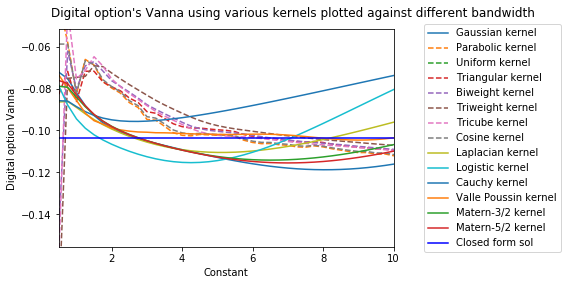

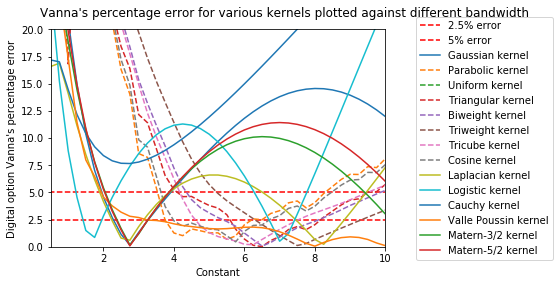

In [258]:
Vanna_plot_AllKernels(0,14,0.5,10)

## Tables

In [88]:
from astropy.table import QTable, Table, Column

### Delta Table

In [110]:
Error_Delta_digital_AllKernels_DiffH=abs(((Delta_digital_AllKernels_DiffH-delta_digoption_clform(S,r,K,Vol,T,t))*100)/delta_digoption_clform(S,r,K,Vol,T,t))


In [111]:
Best_constant_delta=np.zeros(14)
for i in range(14):
    Best_constant_delta[i]=delta_constant[list(Error_Delta_digital_AllKernels_DiffH[i]).index((min(list(Error_Delta_digital_AllKernels_DiffH[i]))))]
                       

In [266]:
Best_constant_delta=np.zeros(14)

In [267]:
X=[2.5,5.5,4.5,6,6.5,7.25,6.5,5.75,1.75,1.25,0.5,3.25,2.25,2.25]

In [269]:
Best_constant_delta=np.zeros(14)
for i in range(14):
    Best_constant_delta[i]=X[i]
                           

In [261]:
Rank_delta=[4,1,2,1,1,1,1,1,5,6,7,3,4,4]

In [263]:
Rule_of_thumb=0.149039

In [264]:
RoT_Bandwidth=np.ones(14)*(Rule_of_thumb)

In [270]:
Best_bandwidth_delta=Best_constant_delta*Rule_of_thumb

In [273]:
Best_bandwidth_delta[8]=0.2608182

In [274]:
Delta_table = Table([kernel_names,RoT_Bandwidth,Best_constant_delta,Best_bandwidth_delta,Rank_delta], names=('kernel Names','Rule of Thumb Bandwidth','Best Constant','Best Bandwidth','Performance Rank'))


In [275]:
Delta_table

kernel Names,Rule of Thumb Bandwidth,Best Constant,Best Bandwidth,Performance Rank
str20,float64,float64,float64,int64
Gaussian kernel,0.149039,2.5,0.3725975,4
Parabolic kernel,0.149039,5.5,0.8197145,1
Uniform kernel,0.149039,4.5,0.6706755,2
Triangular kernel,0.149039,6.0,0.894234,1
Biweight kernel,0.149039,6.5,0.9687535,1
Triweight kernel,0.149039,7.25,1.08053275,1
Tricube kernel,0.149039,6.5,0.9687535,1
Cosine kernel,0.149039,5.75,0.85697425,1
Laplacian kernel,0.149039,1.75,0.2608182,5


### Vega Table

In [77]:
Error_Vega_digital_AllKernels_DiffH=abs(((Vega_digital_AllKernels_DiffH-Vega_digital_clform(S,K,r,T,t,Vol))*100)/Vega_digital_clform(S,K,r,T,t,Vol))


In [78]:
Best_constant_vega=np.zeros(14)
for i in range(14):
    Best_constant_vega[i]=vega_constant[list(Error_Vega_digital_AllKernels_DiffH[i]).index((min(list(Error_Vega_digital_AllKernels_DiffH[i]))))]
                       

In [276]:
Y=[0.5,0.75,0.5,0.75,0.75,1,0.75,0.5,0.5,0.75,1,0.5,0.5,0.75]

In [277]:
Best_constant_vega=np.zeros(14)
for i in range(14):
    Best_constant_vega[i]=Y[i]
                           

In [278]:
Best_constant_vega;

In [279]:
Best_bandwidth_vega=Best_constant_vega*Rule_of_thumb

In [280]:
Rank_vega=[3,1,2,1,1,1,1,1,4,5,7,6,3,3]

In [281]:
Vega_table = Table([kernel_names,RoT_Bandwidth,Best_constant_vega,Best_bandwidth_vega,Rank_vega], names=('Kernel Names','Rule of Thumb Bandwidth','Best Constant','Best Bandwidth','Performance Rank'))


In [282]:
Vega_table

Kernel Names,Rule of Thumb Bandwidth,Best Constant,Best Bandwidth,Performance Rank
str20,float64,float64,float64,int64
Gaussian kernel,0.149039,0.5,0.0745195,3
Parabolic kernel,0.149039,0.75,0.11177925,1
Uniform kernel,0.149039,0.5,0.0745195,2
Triangular kernel,0.149039,0.75,0.11177925,1
Biweight kernel,0.149039,0.75,0.11177925,1
Triweight kernel,0.149039,1.0,0.149039,1
Tricube kernel,0.149039,0.75,0.11177925,1
Cosine kernel,0.149039,0.5,0.0745195,1
Laplacian kernel,0.149039,0.5,0.0745195,4


### Gamma table

In [122]:
Error_Gamma_digital_AllKernels_DiffH=abs((Gamma_digital_AllKernels_DiffH-Gamma_digital_clform(S,K,Vol,r,T,t))*100)/Gamma_digital_clform(S,K,Vol,r,T,t)


In [123]:
Best_constant_Gamma=np.zeros(14)

for i in range(14):
    Best_constant_Gamma[i]=Gamma_constant[list(Error_Gamma_digital_AllKernels_DiffH[i]).index((min(list(Error_Gamma_digital_AllKernels_DiffH[i]))))]
                       

In [293]:
Z=[3,6.25,0.5,6.25,7.75,8.5,7.75,6.5,2,1.75,0.75,1,3,3]

In [294]:
Best_constant_Gamma=np.zeros(14)

for i in range(14):
    Best_constant_Gamma[i]=Z[i]

In [295]:
Best_bandwidth_Gamma=Best_constant_Gamma*Rule_of_thumb

In [296]:
Best_constant_Gamma=list(Best_constant_Gamma)

In [297]:
Best_bandwidth_Gamma=list(Best_bandwidth_Gamma)

In [298]:
Best_constant_Gamma[2]='NA'

In [299]:
Best_bandwidth_Gamma[2]='NA'

In [307]:
Best_bandwidth_Gamma[9]=0.2608182

In [308]:
Rank_Gamma=[2,1,'NA',1,1,1,1,1,3,4,6,5,2,2]

In [309]:
Gamma_table = Table([kernel_names,RoT_Bandwidth,Best_constant_Gamma,Best_bandwidth_Gamma,Rank_Gamma], names=('Kernel Names','Rule of Thumb Bandwidth','Best Constant','Best Bandwidth','Performance Rank'))


In [310]:
Gamma_table

Kernel Names,Rule of Thumb Bandwidth,Best Constant,Best Bandwidth,Performance Rank
str20,float64,str32,str32,str21
Gaussian kernel,0.149039,3.0,0.447117,2
Parabolic kernel,0.149039,6.25,0.93149375,1
Uniform kernel,0.149039,NA,NA,NA
Triangular kernel,0.149039,6.25,0.93149375,1
Biweight kernel,0.149039,7.75,1.15505225,1
Triweight kernel,0.149039,8.5,1.2668315,1
Tricube kernel,0.149039,7.75,1.15505225,1
Cosine kernel,0.149039,6.5,0.9687535,1
Laplacian kernel,0.149039,2.0,0.298078,3


### Vomma Table

In [155]:
Error_Vomma_digital_AllKernels_DiffH=abs((Vomma_digital_AllKernels_DiffH-Vomma_digital_clform(S,K,Vol,r,T,t))*100/Vomma_digital_clform(S,K,Vol,r,T,t))


In [156]:
Best_constant_Vomma=np.zeros(14)

for i in range(14):
    Best_constant_Vomma[i]=Vomma_constant[list(Error_Vomma_digital_AllKernels_DiffH[i]).index((min(list(Error_Vomma_digital_AllKernels_DiffH[i]))))]
                       

In [157]:
Best_constant_Vomma

array([3.  , 5.  , 0.5 , 8.  , 7.5 , 8.5 , 5.25, 4.75, 3.25, 2.  , 1.5 ,
       1.5 , 3.25, 3.25])

In [138]:
Best_bandwidth_Vomma=Best_constant_Vomma*Rule_of_thumb(M,St_last)

In [162]:
Best_constant_Vomma=list(Best_constant_Vomma)

In [163]:
Best_bandwidth_Vomma=list(Best_bandwidth_Vomma)

In [164]:
Best_constant_Vomma[2]='NA'

In [165]:
Best_bandwidth_Vomma[2]='NA'

In [166]:
Rank_Vomma=[2,1,'NA',1,1,1,1,1,2,3,3,3,2,2]

In [322]:
Vomma_table = Table([kernel_names,RoT_Bandwidth,Best_constant_Vomma,Best_bandwidth_Vomma,Rank_Vomma], names=('Kernel Names','Rule of Thumb Bandwidth','Best Constant','Best Bandwidth','Performance Rank'))


In [323]:
Vomma_table

Kernel Names,Rule of Thumb Bandwidth,Best Constant,Best Bandwidth,Performance Rank
str20,float64,str32,str32,str21
Gaussian kernel,0.149039,3.0,0.44815952598109476,2
Parabolic kernel,0.149039,5.0,0.7469325433018247,1
Uniform kernel,0.149039,NA,NA,NA
Triangular kernel,0.149039,8.0,1.1950920692829194,1
Biweight kernel,0.149039,7.5,1.120398814952737,1
Triweight kernel,0.149039,8.5,1.2697853236131018,1
Tricube kernel,0.149039,5.25,0.7842791704669159,1
Cosine kernel,0.149039,4.75,0.7095859161367334,1
Laplacian kernel,0.149039,3.25,0.485506153146186,2


### Vanna table

In [169]:
Error_Vanna_digital_AllKernels_DiffH=abs((Vanna_digital_AllKernels_DiffH-Vanna_digital_clform(S,K,Vol,r,T,t))*100/Vanna_digital_clform(S,K,Vol,r,T,t))


In [178]:
Best_constant_Vanna=np.zeros(14)

for i in range(14):
    Best_constant_Vanna[i]=Vanna_constant[list(Error_Vanna_digital_AllKernels_DiffH[i]).index((min(list(Error_Vanna_digital_AllKernels_DiffH[i]))))]
                       

In [311]:
Z=[2.75,5.75,0.5,5.75,6.25,7,6.25,5.75,2,1,0.75,0.75,2,2.5]

In [312]:
Best_constant_Vanna=np.zeros(14)

for i in range(14):
    Best_constant_Vanna[i]=Z[i]
                       

In [313]:
Best_constant_Vanna

array([2.75, 5.75, 0.5 , 5.75, 6.25, 7.  , 6.25, 5.75, 2.  , 1.  , 0.75,
       0.75, 2.  , 2.5 ])

In [314]:
Best_bandwidth_Vanna=Best_constant_Vanna*Rule_of_thumb

In [315]:
Best_constant_Vanna=list(Best_constant_Vanna)

In [316]:
Best_bandwidth_Vanna=list(Best_bandwidth_Vanna)

In [317]:
Best_constant_Vanna[2]='NA'

In [318]:
Best_bandwidth_Vanna[2]='NA'

In [319]:
Rank_Vanna=[2,1,'NA',1,1,1,1,1,4,3,4,3,2,2]

In [320]:
Vanna_table = Table([kernel_names,RoT_Bandwidth,Best_constant_Vanna,Best_bandwidth_Vanna,Rank_Vanna], names=('Kernel Names','Rule of Thumb Bandwidth','Best Constant','Best Bandwidth','Performance Rank'))


In [321]:
Vanna_table

Kernel Names,Rule of Thumb Bandwidth,Best Constant,Best Bandwidth,Performance Rank
str20,float64,str32,str32,str21
Gaussian kernel,0.149039,2.75,0.40985725,2
Parabolic kernel,0.149039,5.75,0.85697425,1
Uniform kernel,0.149039,NA,NA,NA
Triangular kernel,0.149039,5.75,0.85697425,1
Biweight kernel,0.149039,6.25,0.93149375,1
Triweight kernel,0.149039,7.0,1.0432730000000001,1
Tricube kernel,0.149039,6.25,0.93149375,1
Cosine kernel,0.149039,5.75,0.85697425,1
Laplacian kernel,0.149039,2.0,0.298078,4
